# **Intro M1**
In this notebook I set up semi-supervised VAE to predict cell type proportions from bulk data.
This is the original model structure (M1)
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: cell-type proportion, sample-id, and everything else (slack).
To enforce this disentanglement, there are classification losses on the cell-type and smaple_id embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.



The experimental set-up is as follows:
All data is from pbmc6k dataset.
Cells are sampled to generate 10 pesudobulks.
There are perturbed samples --> this means that for some samples we have mono14 cells instead of mono16 cells. 
This is like a perturbation that would cause one cell type to change.
We use 2 samples as the labeled data (meaning each sample has a ground truth) and 8 samples with unlabeled data (ground truth proportions are not used in training.)




This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae



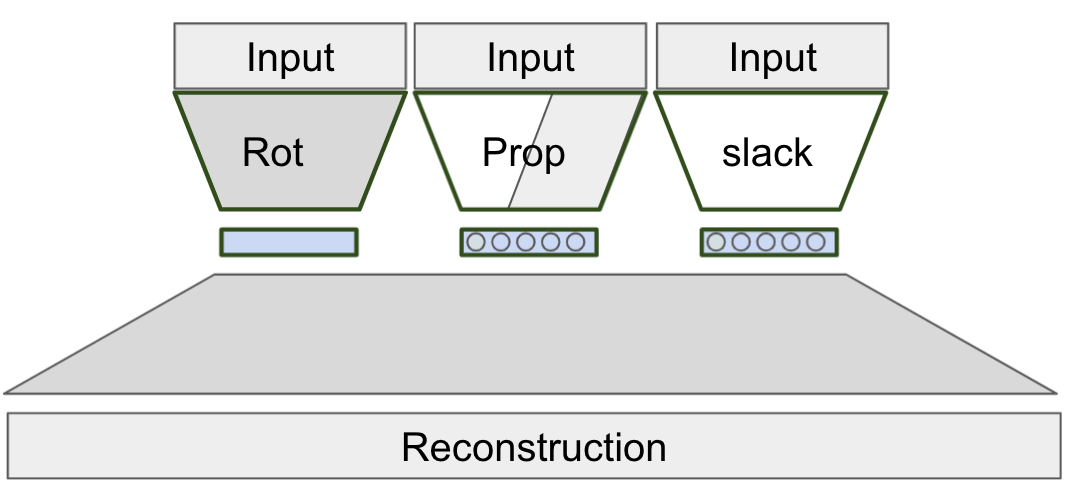

# **Imports**

In [1]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU, ELU, LeakyReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error, KLDivergence
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image

from tqdm import tnrange, tqdm_notebook
import ipywidgets

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# import the SC_preprocessing code
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from sc_preprocessing import sc_preprocess


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [2]:
## parameters
aug_data_path = f"{os.getcwd()}/../data/single_cell_data/augmented_kang_data/"
res_data_path = f"{os.getcwd()}/../results/single_cell_data/buddiM2_kang/"
cibersort_genes_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_phenoclasses.CIBERSORTx_Job17_kang_1_cybersort_sig_inferred_refsample.bm.K999.txt"

# cibersort results
cibersort_file_path = f"{os.getcwd()}/../results/single_cell_data/cibersort_kang/CIBERSORTx_Job18_Results.csv"

# bp results
bp_res_path = f"{os.getcwd()}/../results/single_cell_data/bp_kang/"

num_genes = 7000

exp_id = "kang"

# Set-up experimental variables

In [3]:

##################################################
#####. set up experiment specific variables
##################################################

# number expected cell types
n_cell_types = 10

# number of patients/domains/samples expected
idx_range = range(0, 16)
n_tot_samples = 8 # 8 patients, 2 samples each

# number of drugs (one-hot encoded)
n_drugs = 2

# experiment id
lab_file_name = exp_id

# number of pseudobulks PER patient
n_train = 1000



### create the domains label 
Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 2),
                            np.full(n_train, 3), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 4),
                            np.full(n_train, 5), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 6),
                            np.full(n_train, 7), np.full(n_train, 7)], axis=0)
label_full = to_categorical(Label_full)

### create the drugs label 
Drug_full = np.concatenate([np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0),
                            np.full(n_train, 1), np.full(n_train, 0)], axis=0)
drug_full = to_categorical(Drug_full)


# indexes for the training
# 0, 1 no drug is labeled 
# 0,3-9 is unlabeled

idx_train = np.where(np.logical_and(Label_full < 2, Drug_full == 0))[0] 
idx_unlab = np.where(Label_full >= 2)[0]
idx_drug = np.where(Drug_full > 0)[0]

idx_bulk =  np.where(Label_full >= 2)[0]

In [4]:
idx_bulk.shape

(12000,)

# **Load / Pre-process data**
Import pre-processed pseudobulks

In [5]:

##################################################
#####. Design the experiment
##################################################

# read in the labeled data
X_train, Y_train, gene_df = sc_preprocess.read_all_diva_files(aug_data_path, idx_range, lab_file_name)
X_train.columns = gene_df


# only get genes that are available in both testing and training
common_genes_file = os.path.join(aug_data_path, "kang_genes.pkl")
gene_out_path = Path(common_genes_file)
common_genes = pickle.load(open( gene_out_path, "rb" ))

# try using the cibersort genes
cibersort_df = pd.read_csv(cibersort_genes_path, sep="\t" )
cibersort_genes = cibersort_df["NAME"].values.tolist()

# only keep cibersort genes that are in common genes
cibersort_genes = np.intersect1d(common_genes, cibersort_genes)

X_train = X_train[common_genes]

gene_df = gene_df.loc[gene_df.isin(common_genes)]


# convert to data matrices
X_full = X_train.to_numpy()
Y_full = Y_train.to_numpy()

## get the top variable genes
X_colmean = X_full.mean(axis=0)
X_colvar = X_full.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))
idx_top = np.argpartition(X_CoV, -num_genes)[-num_genes:]
gene_df = gene_df.iloc[idx_top]


In [6]:
np.sort(X_colmean)

array([0.1964375, 0.1983125, 0.218, ..., 736813.628875, 843846.08825,
       1012879.5255], dtype=object)

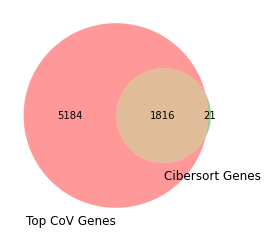

In [7]:

venn2([set(gene_df), set(cibersort_genes)], set_labels = ('Top CoV Genes', 'Cibersort Genes'))
plt.show()

In [8]:
union_genes = np.union1d(gene_df, cibersort_genes)


In [9]:
def pearsonr_2D(x, y):
    """computes pearson correlation coefficient
       where x is a 1D and y a 2D array"""

    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    
    rho = upper / lower
    
    return rho

In [10]:
X_full = X_train.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)
X_full = scaler.transform(X_full)

X_orig = np.copy(X_full)

# get the bulks that are similar to each other
# for each bulk sample
for curr_bulk_idx in range(2,8):
    for perturb_bulk_idx in range(0,2):

        temp_idx_bulk =  np.where(np.logical_and(Label_full == curr_bulk_idx, Drug_full == perturb_bulk_idx))[0]
        if temp_idx_bulk.shape[0] == 0:
            continue

        orig_Y_bulk = np.transpose(Y_full[temp_idx_bulk[0],])
        corr_orig = pearsonr_2D(orig_Y_bulk.astype(float), Y_full[temp_idx_bulk,].astype(float))
        top_corr_idx = np.where(corr_orig > 0.8)[0][0:10]

        # if the Y isn't highly correlated to get enough replicates
        # go to the next one
        corr_bulk_idx = 1
        while top_corr_idx.shape[0] < 10:
            orig_Y_bulk = np.transpose(Y_full[temp_idx_bulk[corr_bulk_idx],])
            corr_orig = pearsonr_2D(orig_Y_bulk.astype(float), Y_full[temp_idx_bulk,].astype(float))
            top_corr_idx = np.where(corr_orig > 0.8)[0][0:10]
            corr_bulk_idx = corr_bulk_idx + 1

        # replace the temp_idx_bulk
        X_temp = np.copy(X_full[temp_idx_bulk,])
        X_temp = X_temp[top_corr_idx,]
        X_temp = np.tile(X_temp, (100, 1))
        X_full[temp_idx_bulk,] = X_temp

        Y_temp = np.copy(Y_full[temp_idx_bulk,])
        Y_temp = Y_temp[top_corr_idx,]
        Y_temp = np.tile(Y_temp, (100, 1))
        Y_full[temp_idx_bulk,] = Y_temp

# for unknown proportions; i.e. 3 
X_unkp = X_full[idx_unlab,]
label_unkp = label_full[idx_unlab,]
drug_unkp = drug_full[idx_unlab,]
y_unkp = Y_full[idx_unlab,]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full[idx_train,]



In [11]:
X_train

gene_ids LINC00115 NOC2L KLHL17 PLEKHN1 HES4  ISG15 AGRN C1orf159 TNFRSF18  \
0                0   446     97     163   66   6985    3        9      999   
0               53   219      0       4  225  18203    4        3      833   
0               10   334      0      14  280  20711    5        1      561   
0               98   239     17       8   49   6571    0       19     3347   
0               35   374     52      97  354  34742    6        9      478   
..             ...   ...    ...     ...  ...    ...  ...      ...      ...   
0                0   683      0       0  101    434    9        0      933   
0                0   340      0       0   71    801    0        0     2092   
0                1   721      0       0  104    296    1        0     1107   
0                0   633      0       0   19    527   19        5      528   
0                1   399      0      10   65    409    1        6     1240   

gene_ids TNFRSF4  ... CPT1B AF127936.5 AJ006998.2 CHODL AP000476.1 LINC00158  \
0            830  ...    11          0          0    21          0         0   
0            181  ...    24          0          5     0          3        83   
0            220  ...     7          1          5     0          0        70   
0            519  ...     1          0          0     0         10        10   
0             90  ...     7          3          0     1          0       133   
..           ...  ...   ...        ...        ...   ...        ...       ...   
0            924  ...     0          0          0     0          0         0   
0            794  ...     0          0          0     0          0         0   
0            406  ...     0          0          0     0          0         0   
0           1528  ...     0          0          0     0          0         0   
0            716  ...     0          0          0     0          0         0   

gene_ids AF131217.1 AP001437.1 TMPRSS3 LRRC3DN  
0                 0          0       0       0  
0                41          0       0       1  
0                 9          0       1       1  
0               126          0       0       0  
0                12          3       2       2  
..              ...        ...     ...     ...  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  
0                 0          0       0       0  

[16000 rows x 13452 columns]

In [12]:
X_ids_temp = X_train.loc[:,union_genes]
X_ids_temp

gene_ids A1BG  A2M A2M-AS1 A4GALT AAED1 AAGAB AAK1  AAMP AARSD1 AASDH  ...  \
0          51    0       0      0    86    70  131   269     51    32  ...   
0          69   38       0      0   220    42  109   184     31    17  ...   
0          19   29       0      0   184    35  496   432     52    61  ...   
0          48    6       0      0    65    57   77   155    154   169  ...   
0          29    0       0      0   273    23  246   277     44    12  ...   
..        ...  ...     ...    ...   ...   ...  ...   ...    ...   ...  ...   
0         249  190       0      0   592    32  102  1658     21   125  ...   
0          88   37       0      1   370    67  101  1815     17    77  ...   
0          34   14       0      0   327    15    8  1864      4    13  ...   
0         186  585       0      0   818     9   27  2345      2   110  ...   
0          91  104       0      0   610    43   65  1501     16    70  ...   

gene_ids ZRSR2 ZSCAN16 ZSCAN21 ZSWIM4 ZUFSP ZWILCH   ZYX ZZEF1 ZZZ3  \
0          110      83       3     31    75      7   107     6  190   
0          113     151       1     62   109      8   295     2   54   
0          133     125       5     10    96      4   343     0   13   
0          155     144      11      2   100      8   161     0  168   
0           82     118       3     75    99      5   338     6   26   
..         ...     ...     ...    ...   ...    ...   ...   ...  ...   
0          149      31     197     67   187     30   745   192  377   
0          235      48     173    108   114      8   227   157  246   
0          323      14      35    122   263      3   117   119   41   
0          289      40      25    426   208     24  1183   221   74   
0          392      73     113    413   152      7   337   164  134   

gene_ids hsa-mir-1199  
0                  38  
0                  35  
0                 187  
0                   1  
0                  77  
..                ...  
0                  32  
0                 173  
0                 102  
0                  26  
0                 142  

[16000 rows x 7021 columns]

In [13]:
Y_full[np.where(np.logical_and(Label_full == 6, Drug_full == 1))[0][1:22],]

array([[0.062, 0.0088, 0.0008, 0.5616, 0.0078, 0.0004, 0.0878, 0.0068,
        0.16, 0.104],
       [0.0902, 0.0376, 0.0186, 0.3616, 0.1978, 0.0478, 0.0188, 0.2016,
        0.0028, 0.0232],
       [0.0034, 0.0686, 0.0316, 0.5832, 0.0344, 0.0008, 0.0848, 0.0116,
        0.1344, 0.0472],
       [0.0182, 0.0184, 0.194, 0.393, 0.1774, 0.012, 0.057, 0.1098,
        0.0112, 0.009],
       [0.0094, 0.0448, 0.0842, 0.3948, 0.0734, 0.118, 0.0386, 0.0072,
        0.013, 0.2166],
       [0.0134, 0.0026, 0.0008, 0.8856, 0.0054, 0.0102, 0.0002, 0.0044,
        0.0282, 0.0492],
       [0.031, 0.0004, 0.0056, 0.876, 0.0002, 0.0002, 0.0348, 0.0106,
        0.0006, 0.0406],
       [0.1278, 0.0328, 0.0102, 0.6174, 0.0274, 0.0022, 0.0118, 0.1668,
        0.0018, 0.0018],
       [0.0716, 0.0008, 0.0222, 0.5748, 0.0226, 0.0632, 0.051, 0.0954,
        0.0238, 0.0746],
       [0.0, 0.0168, 0.0024, 0.76, 0.0412, 0.0106, 0.0, 0.1448, 0.0234,
        0.0008],
       [0.062, 0.0088, 0.0008, 0.5616, 0.0078, 0.000

In [14]:
Y_train

B CD4_Mem_T CD4_Naive_T   CD8_T CD14_Mono CD16_Mono      DC      Mk  \
0   0.3536    0.5928       0.034  0.0004     0.002    0.0012  0.0002  0.0124   
0   0.0074    0.0004      0.0058  0.5038    0.0314    0.1418  0.1556  0.0016   
0   0.0144    0.0144      0.2996    0.04     0.022    0.1748  0.0832  0.2066   
0   0.0178    0.0078       0.002  0.0006    0.0002    0.0006  0.0228   0.004   
0   0.2266     0.012      0.0022    0.11    0.3442    0.1452  0.0204   0.098   
..     ...       ...         ...     ...       ...       ...     ...     ...   
0   0.0034     0.218        0.05  0.0022    0.0006     0.047  0.0006  0.5086   
0   0.0114    0.0078      0.0494   0.008    0.1352    0.0022  0.0436  0.5912   
0   0.1084    0.0346      0.0018  0.0056    0.2428    0.0006  0.0082  0.5958   
0   0.0198    0.0016       0.016  0.0406    0.0328    0.0006  0.0162    0.87   
0   0.0112    0.0048       0.008  0.0522    0.0014    0.0086  0.0118  0.7218   

        NK   T_Act  
0    0.002  0.0014  
0   0.0888  0.0634  
0    0.026   0.119  
0   0.9434  0.0008  
0   0.0154   0.026  
..     ...     ...  
0   0.0152  0.1544  
0   0.0016  0.1496  
0   0.0004  0.0018  
0    0.001  0.0014  
0   0.1428  0.0374  

[16000 rows x 10 columns]

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16000 samples in 0.093s...
[t-SNE] Computed neighbors for 16000 samples in 19.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for s

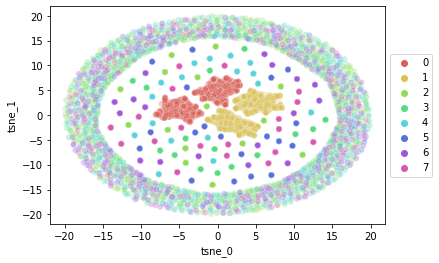

In [15]:
## plot samples
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_full)

plot_df = pd.DataFrame(tsne_results[:,0:2])
print(tsne_results.shape)
print(plot_df.shape)
plot_df.columns = ['tsne_0', 'tsne_1']
plot_df['augmentation'] = Label_full

g = sns.scatterplot(
    x="tsne_0", y="tsne_1",
    data=plot_df,
    hue="augmentation",
    palette=sns.color_palette("hls", n_tot_samples),
    legend="full",
    alpha=0.3
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [16]:
idx_9 = np.where(Label_full == 9)[0]
true_9_prop_df = Y_train.iloc[idx_9]
X_unkp_9 = X_full[idx_9,]


# **M2 Model Definition**

## Hyperparameters

In [17]:

##################################################
#####. Hyperparameters
##################################################

batch_size = 500
n_epoch = 100 # 500 

alpha_rot = 1000000 #1000000
alpha_drug = 10000 #1000000
alpha_prop = 100 #100

beta_kl_slack = 0.1 # 10 ###
beta_kl_rot = 100 # 100 ###
beta_kl_drug = 100 # 100 ###


n_x = X_full.shape[1]
n_y = Y_full.shape[1]
n_label = n_tot_samples  # 8 donors 
n_drugs = n_drugs  # number of drugs one-hot encoded
n_label_z = 64  # 64 dimensional representation of rotation


# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = Y_full.shape[1] # latent space size, one latent dimension PER cell type
encoder_dim = 512 # dim of encoder hidden layer 512 
decoder_dim = 512 # dim of encoder hidden layer 512 
decoder_out_dim = n_x # dim of decoder output layer

# labeled classifier
class_dim1 = 512 # 512 
class_dim2 = 256 # 256 


activ = 'relu'
optim = Adam(learning_rate=0.0005) #0.001
print(f"length of X {n_x} and length of y {n_y} n_label {n_label} and n_drugs {n_drugs}")



length of X 7021 and length of y 10 n_label 8 and n_drugs 2


## Encoder + Y classifier

In [18]:
# declare the Keras tensor we will use as input to the encoder
X = Input(shape=(n_x,))
Y = Input(shape=(n_y,))
label = Input(shape=(n_label,))
props = Input(shape=(n_y,))
z_in = Input(shape=(n_y+n_label_z+n_label_z+n_label_z,))
cls_in = Input(shape=(n_label_z,))

inputs = X

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_s = Dense(encoder_dim, activation=activ, name="encoder_slack")(inputs)
encoder_r = Dense(encoder_dim, activation=activ, name="encoder_rot")(inputs)
encoder_d = Dense(encoder_dim, activation=activ, name="encoder_drug")(inputs)

# now from the hidden layer, you get the mu and sigma for 
# the latent space

mu_slack = Dense(n_label_z, activation='linear', name = "mu_slack")(encoder_s)
l_sigma_slack = Dense(n_label_z, activation='linear', name = "sigma_slack")(encoder_s)

mu_rot = Dense(n_label_z, activation='linear', name = "mu_rot")(encoder_r)
l_sigma_rot = Dense(n_label_z, activation='linear', name = "sigma_rot")(encoder_r)


mu_drug = Dense(n_label_z, activation='linear', name = "mu_drug")(encoder_d)
l_sigma_drug = Dense(n_label_z, activation='linear', name = "sigma_drug")(encoder_d)



# set up labeled classifier
#defining the architecture of the classifier

class_hidden1 = Dense(class_dim1, activation=activ, name = "cls_h1")
class_hidden2 = Dense(class_dim2, activation=activ, name="cls_h2")
class_out = Dense(n_y, activation='softmax', name="cls_out")

#x_concat_lab = tf.keras.layers.concatenate([inputs, label])
#classifier_h1 = class_hidden1(tf.keras.layers.Concatenate()([inputs, label]))
classifier_h1 = class_hidden1(inputs)
classifier_h2 = class_hidden2(classifier_h1)
Y_cls = class_out(classifier_h2)



## Latent Space

In [19]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma, n_z = args
    eps = K.random_normal(shape=(batch_size, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z_slack = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_slack")([mu_slack, l_sigma_slack, n_label_z])
z_rot = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_rot")([mu_rot, l_sigma_rot, n_label_z])
z_drug = Lambda(sample_z, output_shape = (n_label_z, ), name="z_samp_drug")([mu_drug, l_sigma_drug, n_label_z])

z_concat_lab = concat([z_slack, Y, z_rot, z_drug])
z_concat_unlab = concat([z_slack, Y_cls, z_rot, z_drug])

2023-03-03 17:59:18.921801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Decoder + Classifiers

In [20]:
def null_f(args):
    return args

###### DECODER
# set up decoder network
# this is a decoder with 512 hidden layer
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")

# final reconstruction
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")

d_in = Input(shape=(n_label_z+n_y+n_label_z+n_label_z,))
d_h1 = decoder_hidden(d_in)
d_out = decoder_out(d_h1)

# set up the decoder part that links to the encoder
# labeled decoder
h_lab = decoder_hidden(z_concat_lab)
outputs_lab = decoder_out(h_lab)

# unlabeled decoder
h_unlab = decoder_hidden(z_concat_unlab)
outputs_unlab = decoder_out(h_unlab)


###### Rotations classifier
# this is the rotation we try to estimate
rot_h1 = ReLU(name = "rot_h1")
rot_h2 = Dense(n_label, activation='linear', name = "rot_h2")
rot_softmax = Softmax(name = "mu_rot_pred")
decoder_sigma_r = Lambda(null_f, name = "l_sigma_rot_pred")


rot_1_out = rot_h1(z_rot)
rot_2_out = rot_h2(rot_1_out)
rotation_outputs = rot_softmax(rot_2_out)
sigma_outputs_r = decoder_sigma_r(l_sigma_rot)



###### Drug classifier
# this is the drug we try to estimate
drug_h1 = ReLU(name = "drug_h1")
drug_h2 = Dense(n_drugs, activation='linear', name = "drug_h2")
drug_softmax = Softmax(name = "mu_drug_pred")
decoder_sigma_d = Lambda(null_f, name = "l_sigma_drug_pred")


drug_1_out = drug_h1(z_drug)
drug_2_out = drug_h2(drug_1_out)
drug_outputs = drug_softmax(drug_2_out)
sigma_outputs_d = decoder_sigma_d(l_sigma_drug)








## Loss

In [21]:

def vae_loss(y_true, y_pred):
    recon = K.sum(mean_squared_error(y_true, y_pred), axis=-1)
    kl_rot = beta_kl_rot * K.sum(K.exp(l_sigma_rot) + K.square(mu_rot) - 1. - l_sigma_rot, axis=-1)
    kl_drug = beta_kl_drug * K.sum(K.exp(l_sigma_drug) + K.square(mu_drug) - 1. - l_sigma_drug, axis=-1)
    kl_slack = beta_kl_slack * K.sum(K.exp(l_sigma_slack) + K.square(mu_slack) - 1. - l_sigma_slack, axis=-1)
    return recon + kl_rot +kl_drug+ kl_slack


def recon_loss(y_true, y_pred):
	return K.sum(mean_squared_error(y_true, y_pred), axis=-1)


def prop_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_prop

def drug_loss(y_true, y_pred):
  return K.sum(mean_absolute_error(y_true, y_pred), axis=-1) * alpha_drug


def class_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)*alpha_rot
    return recon



## Make the computational graph

In [22]:
classifier = Model(X, Y_cls)

known_prop_vae = Model([X, Y], [outputs_lab, Y_cls, rotation_outputs, drug_outputs])
unknown_prop_vae = Model(X, [outputs_unlab, rotation_outputs, drug_outputs])

known_prop_vae.compile(optimizer=optim, loss=[vae_loss, prop_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])
unknown_prop_vae.compile(optimizer=optim, loss=[vae_loss, class_loss, drug_loss]) #, metrics = [KL_loss, recon_loss])

encoder_unlab = Model(X, [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])

encoder_lab = Model([X, Y], [z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug])


decoder = Model(d_in, d_out)


print(known_prop_vae.summary())
print(unknown_prop_vae.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7021)]       0                                            
__________________________________________________________________________________________________
encoder_slack (Dense)           (None, 512)          3595264     input_1[0][0]                    
__________________________________________________________________________________________________
encoder_rot (Dense)             (None, 512)          3595264     input_1[0][0]                    
__________________________________________________________________________________________________
encoder_drug (Dense)            (None, 512)          3595264     input_1[0][0]                    
____________________________________________________________________________________________

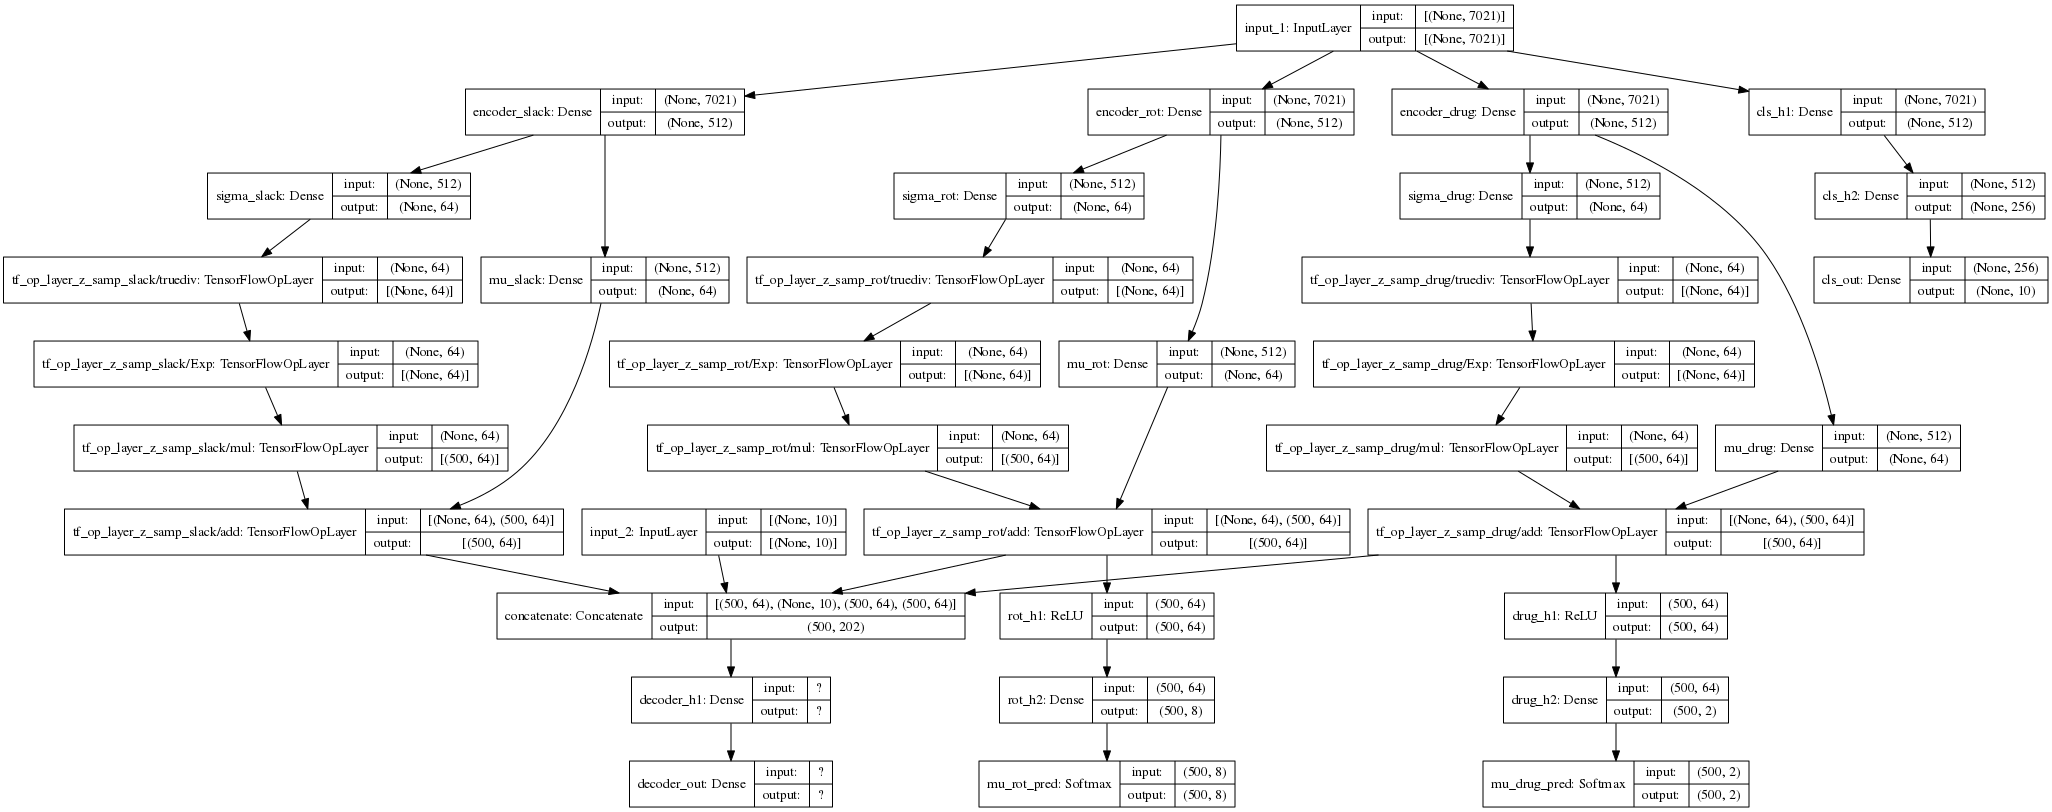

In [23]:
display(plot_model(known_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

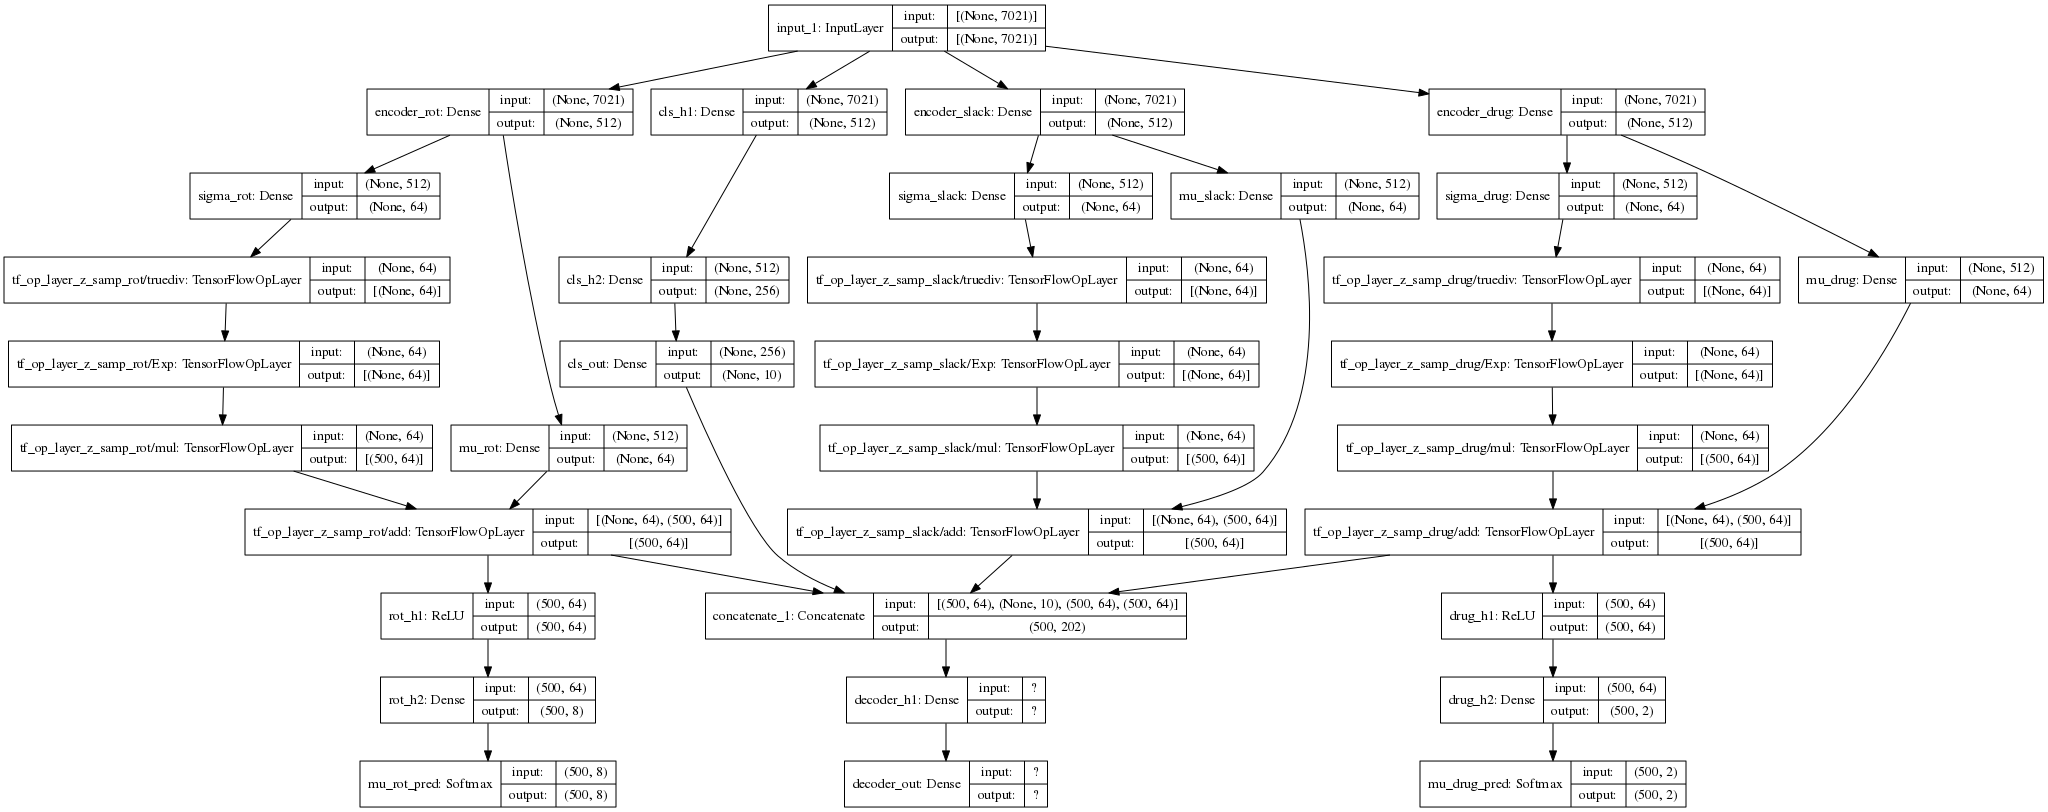

In [24]:
display(plot_model(unknown_prop_vae, show_layer_names=True, show_shapes=True, dpi=72))

# **Training**

Here we train using both the known and unknown cell-type proportions.
The labeled data is repeated in order to match the dimension of the unlabeled data so that they have the same batch size.
This code is taken from https://github.com/bjlkeng/sandbox/blob/master/notebooks/vae-semi_supervised_learning/vae-m2-fit-mnist.ipynb

In [25]:


def fit_model(X_unknown_prop, label_unknown_prop, drug_unknown_prop, X_known_prop, Y_known_prop, label_known_prop, drug_known_prop, epochs):
    assert len(X_unknown_prop) % len(X_known_prop) == 0, \
            (len(X_unknown_prop), batch_size, len(X_known_prop))
    start = time.time()
    history = []
    meta_hist = []
    
    for epoch in range(epochs):
        unlabeled_index = np.arange(len(X_unknown_prop))
        np.random.shuffle(unlabeled_index)

        # Repeat the unlabeled data to match length of labeled data
        labeled_index = []
        for i in range(len(X_unknown_prop) // len(X_known_prop)):
            l = np.arange(len(X_known_prop))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unknown_prop) // batch_size
        for i in range(batches):
            # Labeled
            index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
            loss = known_prop_vae.train_on_batch([X_known_prop[index_range], Y_known_prop[index_range]],
                                                    [X_known_prop[index_range], Y_known_prop[index_range], label_known_prop[index_range], drug_known_prop[index_range]])
            meta_hist.append(i)

            # Unlabeled
            index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
            loss += [unknown_prop_vae.train_on_batch(X_unknown_prop[index_range],
                                                        [X_unknown_prop[index_range], label_unknown_prop[index_range], drug_unknown_prop[index_range]])]

            meta_hist.append(i)

            history.append(loss)
            
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return [history, meta_hist]

In [26]:
for layer in classifier.layers:
    print(layer)

In [27]:
for layer in encoder_unlab.layers:
    print(layer.name)

input_1
encoder_slack
encoder_rot
encoder_drug
sigma_slack
sigma_rot
sigma_drug
tf_op_layer_z_samp_slack/truediv
tf_op_layer_z_samp_rot/truediv
tf_op_layer_z_samp_drug/truediv
tf_op_layer_z_samp_slack/Exp
tf_op_layer_z_samp_rot/Exp
tf_op_layer_z_samp_drug/Exp
mu_slack
tf_op_layer_z_samp_slack/mul
mu_rot
tf_op_layer_z_samp_rot/mul
mu_drug
tf_op_layer_z_samp_drug/mul
tf_op_layer_z_samp_slack/add
tf_op_layer_z_samp_rot/add
tf_op_layer_z_samp_drug/add


Now train

In [28]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


In [29]:
# X_unknown_prop, label_unknown_prop, X_known_prop, Y_known_prop, label_known_prop
loss_history = fit_model(X_unkp,
                    label_unkp,
                    drug_unkp,
                    X_kp, 
                    y_kp,
                    label_kp, 
                    drug_kp, epochs=n_epoch)



Elapsed:  1020.036737203598


In [30]:
meta_history = loss_history[1]
loss_history = loss_history[0]

# Plot Loss Curves

In [31]:
# write out the loss for later plotting
# unpack the loss values
labeled_total_loss = [item[0] for item in loss_history]
unlabeled_total_loss = [item[5][0] for item in loss_history]

labeled_recon_loss = [item[1] for item in loss_history]
unlabeled_recon_loss = [item[5][1] for item in loss_history]

labeled_prop_loss = [item[2] for item in loss_history]

labeled_samp_loss = [item[3] for item in loss_history]
unlabeled_samp_loss = [item[5][2] for item in loss_history]

labeled_drug_loss = [item[4] for item in loss_history]
unlabeled_drug_loss = [item[5][2] for item in loss_history]


# make into a dataframe
total_loss = labeled_total_loss + unlabeled_total_loss + [a + b for a, b in zip(labeled_total_loss, unlabeled_total_loss)]
loss_df = pd.DataFrame(data=total_loss, columns=['total_loss'])
loss_df['type'] = ["labeled"]*len(loss_history) + ["unlabeled"]*len(loss_history) + ["sum"]*len(loss_history)
loss_df['batch'] = [*range(len(loss_history))] + [*range(len(loss_history))] + [*range(len(loss_history))]

recon_loss = labeled_recon_loss + unlabeled_recon_loss + [a + b for a, b in zip(labeled_recon_loss, unlabeled_recon_loss)]
loss_df['recon_loss'] = recon_loss

prop_loss = labeled_prop_loss + [0]*len(loss_history) + labeled_prop_loss
loss_df['prop_loss'] = prop_loss

samp_loss = labeled_samp_loss + unlabeled_samp_loss + [a + b for a, b in zip(labeled_samp_loss, unlabeled_samp_loss)]
loss_df['samp_loss'] = samp_loss


drug_loss = labeled_drug_loss + unlabeled_drug_loss + [a + b for a, b in zip(labeled_drug_loss, unlabeled_drug_loss)]
loss_df['drug_loss'] = drug_loss



In [32]:
loss_df

total_loss     type  batch     recon_loss    prop_loss     samp_loss  \
0     7.392557e+06  labeled      0    6322.478027  5724.574219  3.571958e+06   
1     8.682591e+05  labeled      1   62460.089844  6790.570801  7.989176e+05   
2     7.025201e+05  labeled      2  110051.773438  6280.898438  5.861858e+05   
3     4.581560e+05  labeled      3  136434.968750  6952.833008  3.147682e+05   
4     2.437152e+05  labeled      4  145341.531250  6971.565918  9.140206e+04   
...            ...      ...    ...            ...          ...           ...   
7195  4.572059e+04      sum   2395   43927.269531   329.757080  1.241769e+03   
7196  4.545410e+04      sum   2396   43552.867188   382.238159  1.365749e+03   
7197  4.525262e+04      sum   2397   43667.925781   367.920166  1.067737e+03   
7198  4.494853e+04      sum   2398   43637.230469   347.042786  7.993627e+02   
7199  4.506209e+04      sum   2399   43681.476562   379.400482  8.651730e+02   

         drug_loss  
0     3.808552e+06  
1     9.078888e+01  
2     1.625937e+00  
3     1.053380e-01  
4     5.513935e-02  
...            ...  
7195  8.775483e+02  
7196  9.882673e+02  
7197  7.754698e+02  
7198  5.906424e+02  
7199  5.382734e+02  

[7200 rows x 7 columns]

In [33]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g

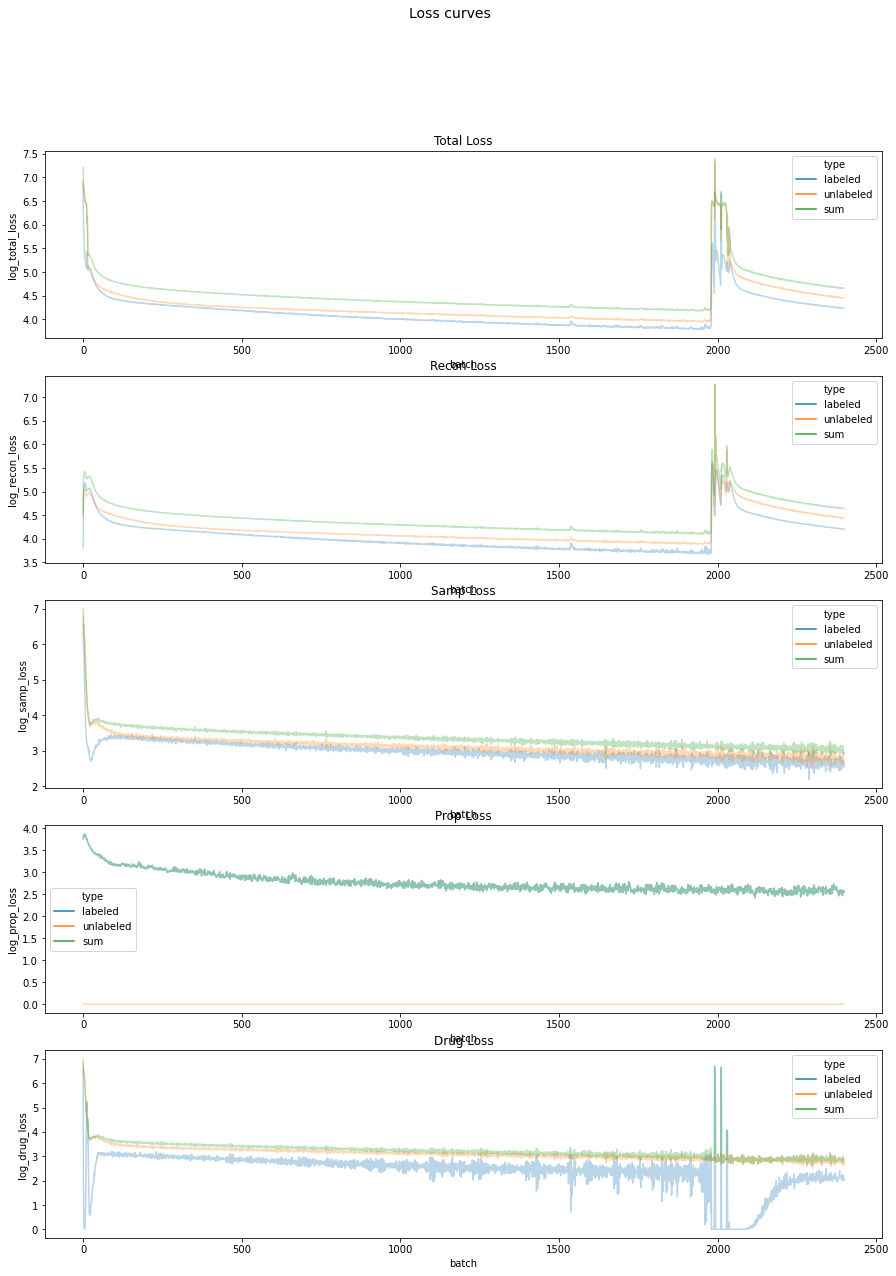

In [34]:

# add the log to make it easier to plot
loss_df["log_total_loss"] = np.log10(loss_df["total_loss"]+1)
loss_df["log_recon_loss"] = np.log10(loss_df["recon_loss"]+1)
loss_df["log_samp_loss"] = np.log10(loss_df["samp_loss"]+1)
loss_df["log_prop_loss"] = np.log10(loss_df["prop_loss"]+1)
loss_df["log_drug_loss"] = np.log10(loss_df["drug_loss"]+1)


fig, axs = plt.subplots(5, figsize=(15,20))

make_loss_fig(loss_df, ax=axs[0], title=f"Total Loss", loss_to_plot="log_total_loss")
make_loss_fig(loss_df, ax=axs[1], title=f"Recon Loss", loss_to_plot="log_recon_loss")
make_loss_fig(loss_df, ax=axs[2], title=f"Samp Loss", loss_to_plot="log_samp_loss")
make_loss_fig(loss_df, ax=axs[3], title=f"Prop Loss", loss_to_plot="log_prop_loss")
make_loss_fig(loss_df, ax=axs[4], title=f"Drug Loss", loss_to_plot="log_drug_loss")


fig.suptitle("Loss curves", fontsize=14)

fig.show()

In [35]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab, class_id):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g


def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


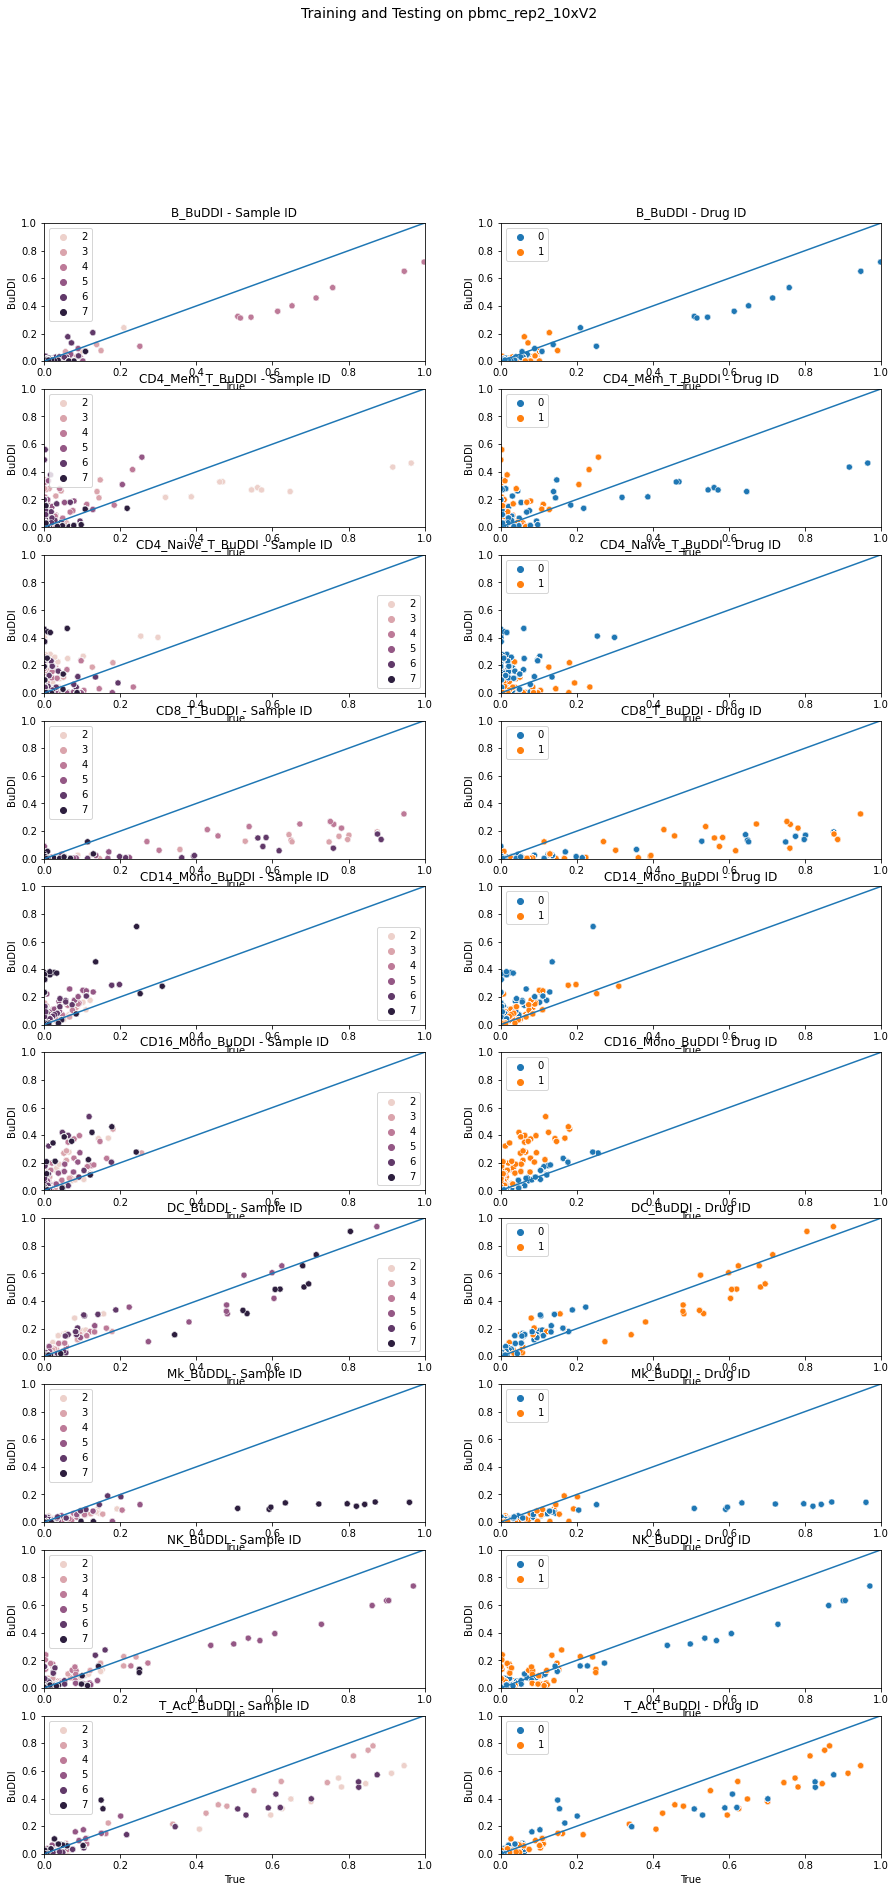

In [36]:
idx_tmp = np.where(Label_full >= 2)[0]
X_tmp = X_full[idx_tmp,]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled

prop_df = pd.DataFrame(prop_outputs, columns=Y_train.columns)
true_prop_df = Y_train.iloc[idx_tmp]

fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI - Sample ID", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BuDDI - Drug ID", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

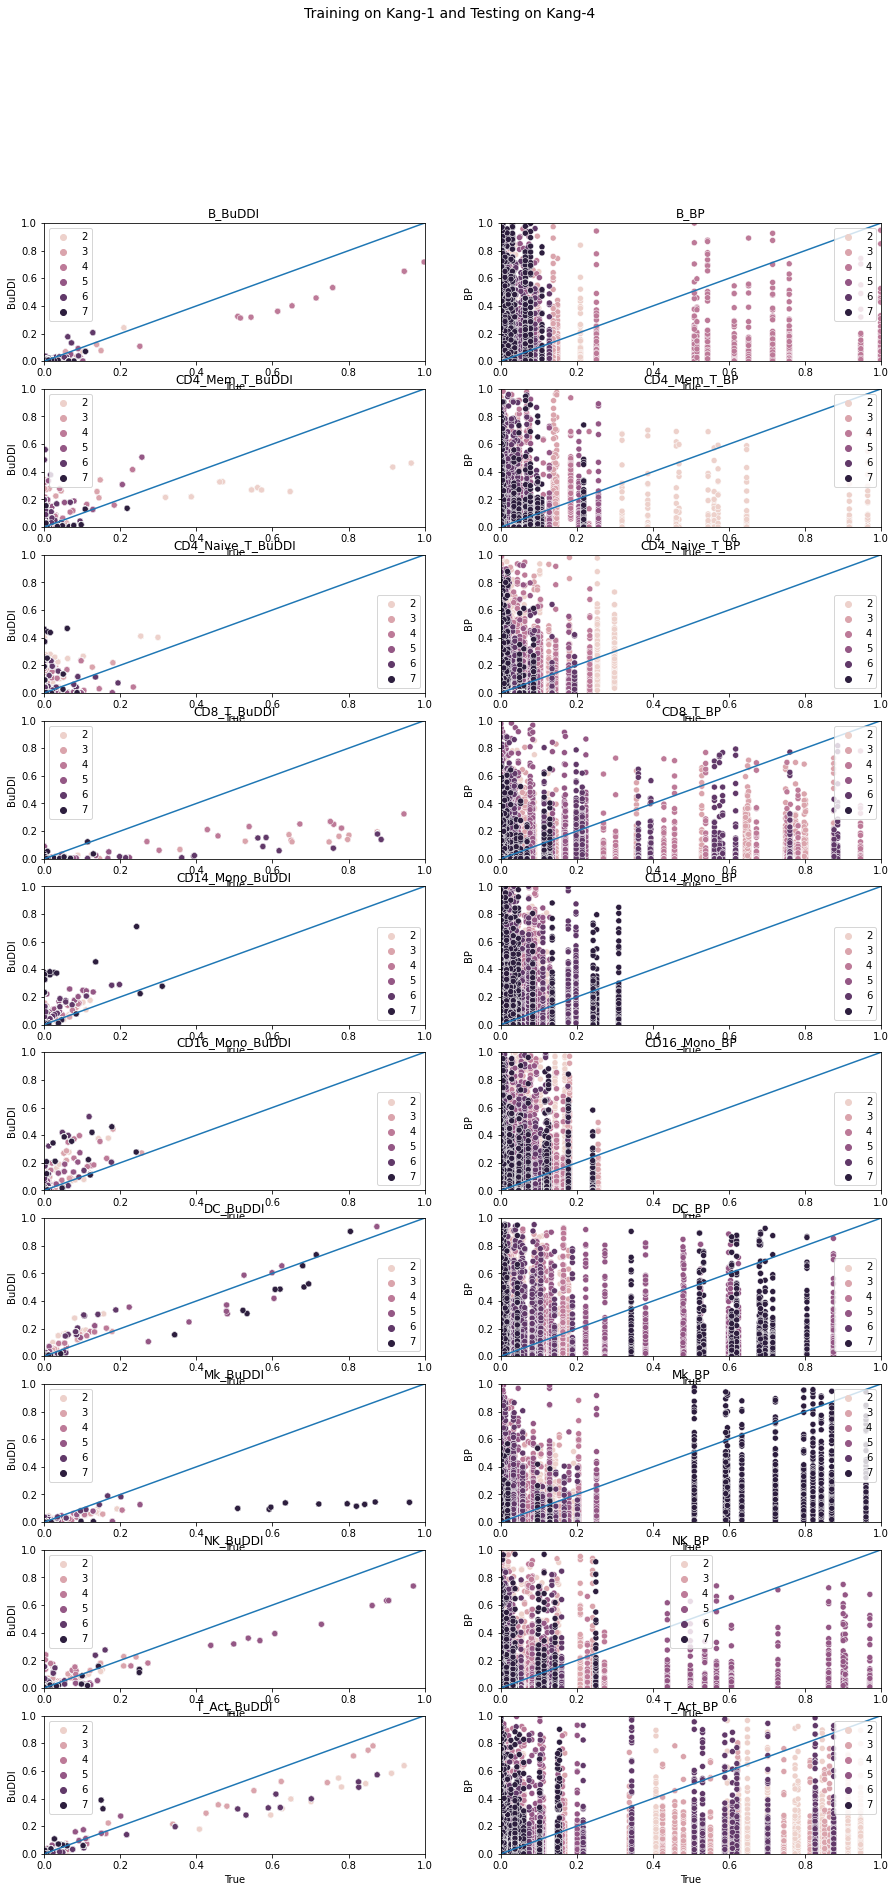

In [37]:
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]

y_cols = [str(x) for x in Y_train.columns]


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=y_cols)
true_prop_df = Y_train.iloc[idx_tmp]



fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Label_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], bp_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP", class_id=Label_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training on Kang-1 and Testing on Kang-4", fontsize=14)

fig.show()

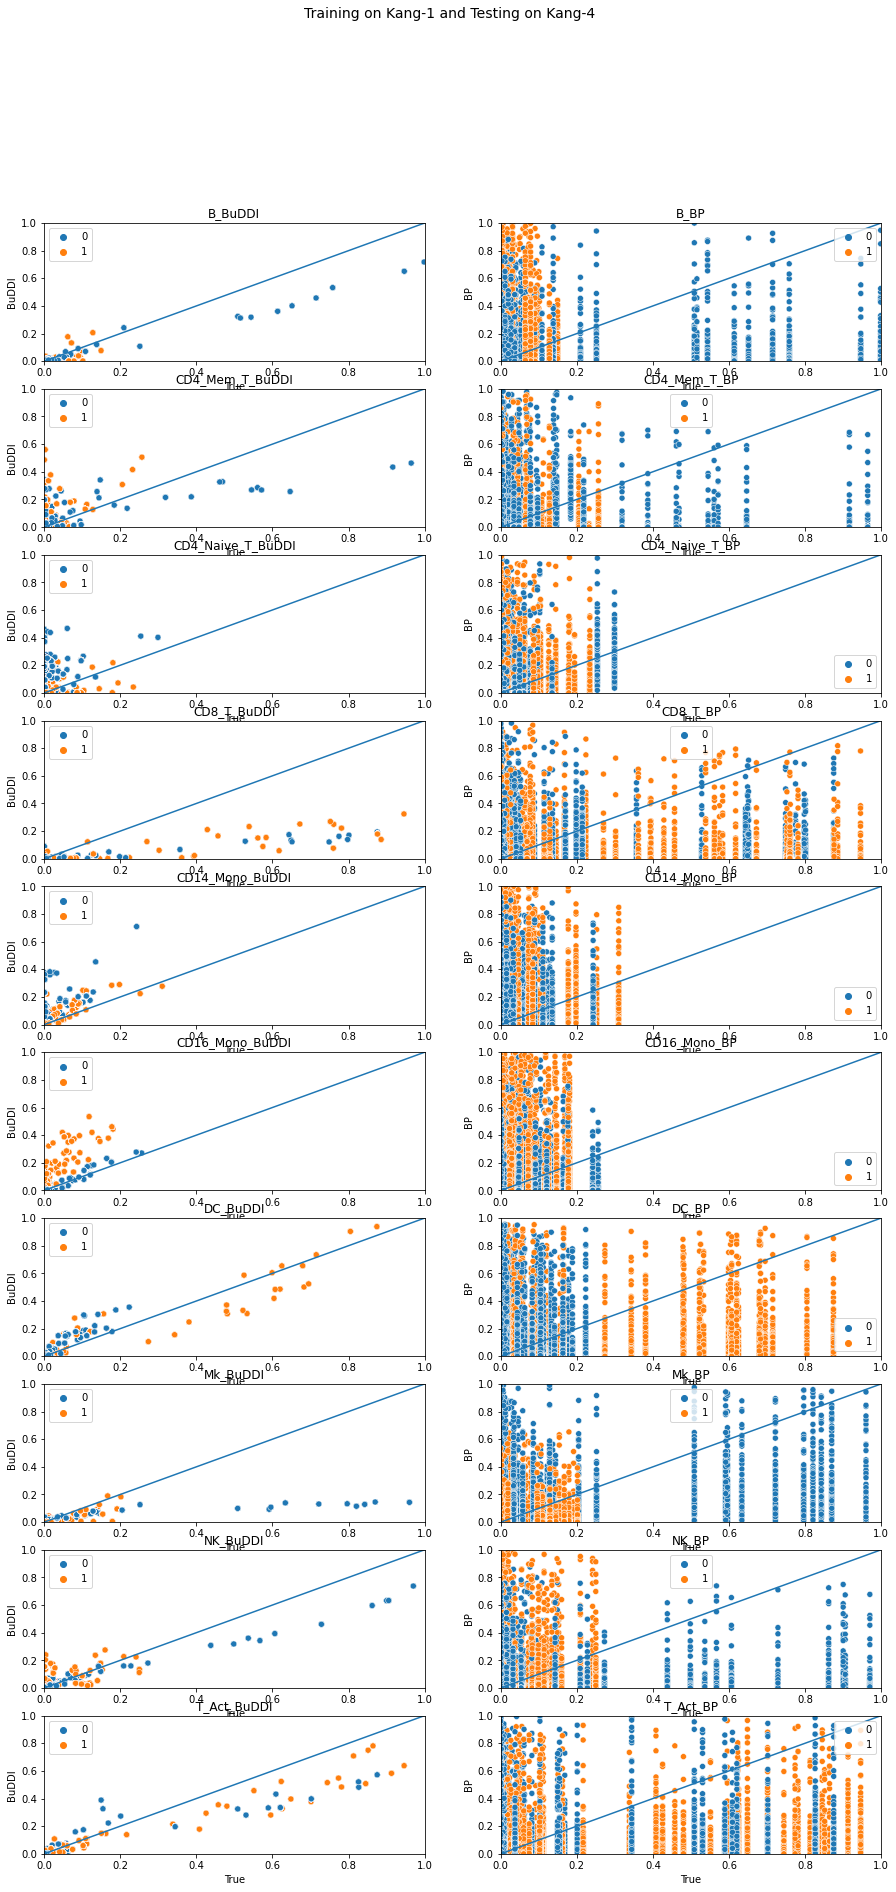

In [38]:
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]

y_cols = [str(x) for x in Y_train.columns]


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

## plot for the unlabeled
prop_df = pd.DataFrame(prop_outputs, columns=y_cols)
true_prop_df = Y_train.iloc[idx_tmp]



fig, axs = plt.subplots(10, 2, figsize=(15,30))
row_idx = 0
for curr_cell in true_prop_df.columns:

    plot_cell_specific_corr(true_prop_df[curr_cell], prop_df[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI", class_id=Drug_full[idx_tmp])
    plot_cell_specific_corr(true_prop_df[curr_cell], bp_df[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP", class_id=Drug_full[idx_tmp])
    row_idx = row_idx +1


fig.suptitle("Training on Kang-1 and Testing on Kang-4", fontsize=14)

fig.show()

### compare errors

In [39]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df




In [40]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_errors_single(y_true, y_est):
  mse_err = [mean_sqr_error(y_true, y_est)]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true, y_est)[0]]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true, y_est)[0]]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df




MSqE mean: 0.013311331447267752, median: 0.01346953802072709, max: 0.015934484340095707
Spearman mean: 0.5319297698435355, median: 0.6242424242424243, max: 0.8060606060606059
Pearson mean: 0.8196084979844838, median: 0.8812276679653562, max: 0.9632021527465621
MSqE mean: 0.06429782443474744, median: 0.0626583282293328, max: 0.1487212452042999
Spearman mean: 0.09543246303778345, median: 0.10871604294910911, max: 0.8254031273145536
Pearson mean: 0.013251651506668119, median: -0.06994129376418226, max: 0.9596704522091765
MSqE mean: 0.07603602945861655, median: 0.07452865298262801, max: 0.18502048500523308
Spearman mean: -0.01668740534095157, median: -0.006060606060606061, max: 0.8787878787878788
Pearson mean: -0.04725535380857838, median: -0.15047832365687025, max: 0.9841870151550602


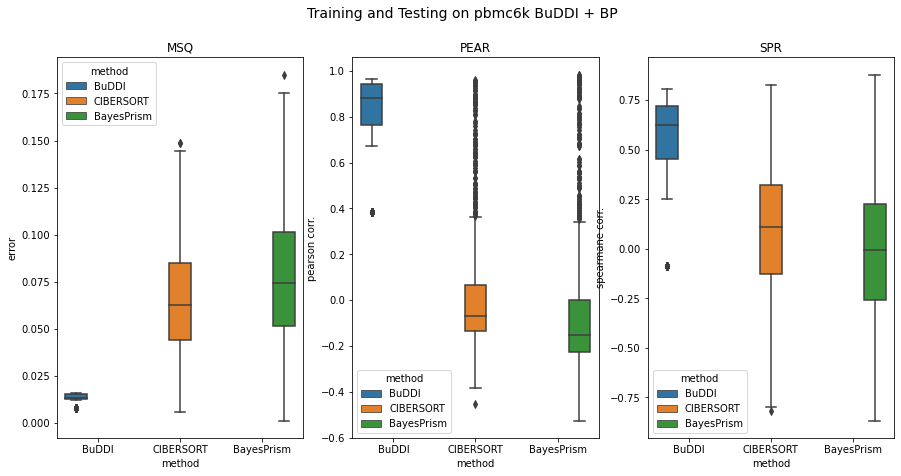

In [41]:
# We only ran the cibersort on index 9
idx_9 = np.where(np.logical_and(Label_full == 2, Drug_full == 1))[0]
X_tmp = X_full[idx_9,]
Y_tmp = Y_train.iloc[idx_9]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# read in cibersort
cibersort_df = pd.read_csv(cibersort_file_path)
cibersort_df = cibersort_df.reindex(columns=Y_train.columns, fill_value=0)


# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)
bp_df = bp_df.iloc[range(2000, 3000)] 


# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
cibersort_err = get_errors(Y_tmp.to_numpy(), cibersort_df.to_numpy())
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy())

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]

cibersort_err["experiment"] = ["true_val"]*cibersort_err.shape[0]
cibersort_err["method"] = ["CIBERSORT"]*cibersort_err.shape[0]

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]

plot_df = pd.concat([buddi_err, cibersort_err, bp_err])

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training on 1, testing on 4", fontsize=14)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="method", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)


fig.show()

MSqE mean: 0.02139676931321073, median: 0.012594616059456885, max: 0.10219828378026845
Spearman mean: 0.4980446662455685, median: 0.5515151515151515, max: 0.9151515151515152
Pearson mean: 0.6240545675517594, median: 0.7068276454356859, max: 0.9947767660337083
MSqE mean: 0.06396900898781005, median: 0.06074448927530897, max: 0.19831868273216596
Spearman mean: 0.015910107889950842, median: 0.006079055436800647, max: 0.9272727272727272
Pearson mean: 0.027699698005161772, median: -0.0892991868119056, max: 0.9982252042315795


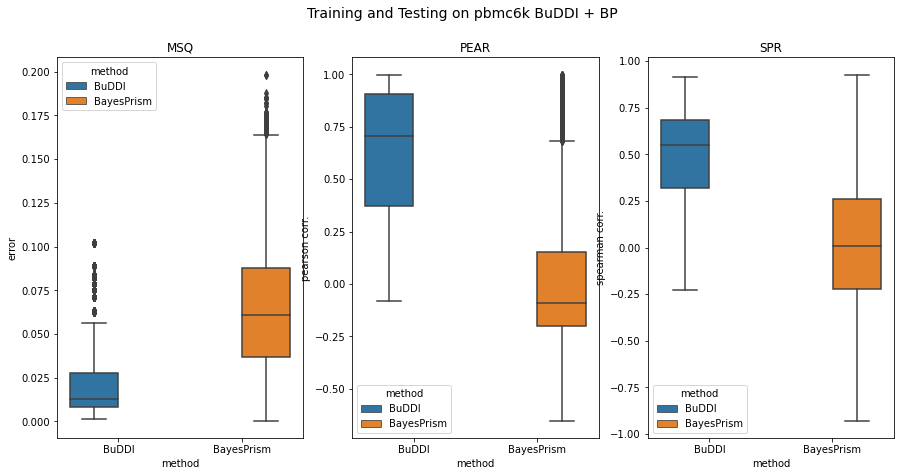

In [42]:

X_tmp = X_full[idx_tmp,]
Y_tmp = Y_train.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# read in BP
bp_df  = read_bp_result_file(bp_res_path, "kang", "kang", num_samp=14000)
bp_df = bp_df.reindex(columns=y_cols, fill_value=0)


# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy()[2000:14000,])

# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]

plot_df = pd.concat([buddi_err, bp_err])

# plot
fig, axs = plt.subplots(1, 3, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training on 1, testing on 4", fontsize=14)


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="method", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearman corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)


fig.show()

MSqE mean: 0.02139676931321073, median: 0.012594616059456885, max: 0.10219828378026845
Spearman mean: 0.4980446662455685, median: 0.5515151515151515, max: 0.9151515151515152
Pearson mean: 0.6240545675517594, median: 0.7068276454356859, max: 0.9947767660337083
MSqE mean: 0.06396900898781005, median: 0.06074448927530897, max: 0.19831868273216596
Spearman mean: 0.015910107889950842, median: 0.006079055436800647, max: 0.9272727272727272
Pearson mean: 0.027699698005161772, median: -0.0892991868119056, max: 0.9982252042315795


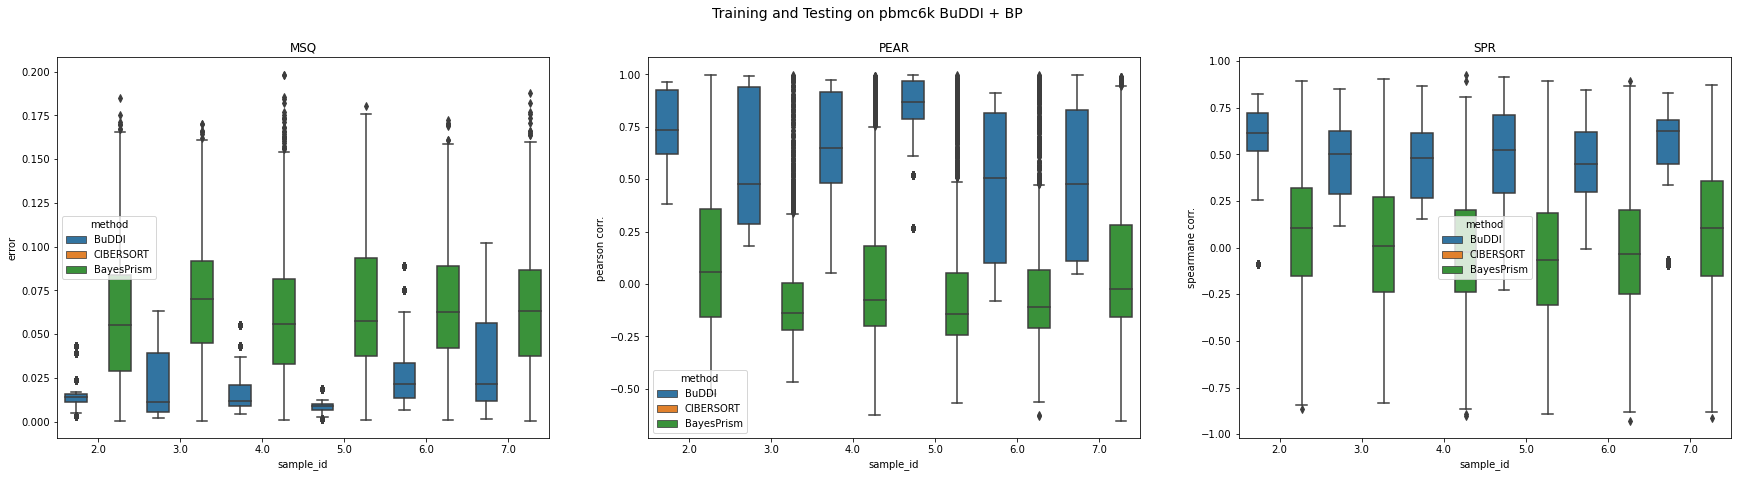

In [43]:
# Now compare across samples
idx_tmp = idx_unlab
num_unlab = np.array([0,1,2,2,3,3,4,4,5,5,6,6,7,7])
num_unlab = np.array([2,2,3,3,4,4,5,5,6,6,7,7])
idx_tmp = idx_unlab
X_tmp = X_full[idx_tmp,]
Y_tmp = Y_train.iloc[idx_tmp]

# make predictions
prop_outputs = classifier.predict(X_tmp, batch_size=batch_size)

# calculate the error
buddi_err = get_errors(Y_tmp.to_numpy(), prop_outputs)
bp_err = get_errors(Y_tmp.to_numpy(), bp_df.to_numpy()[2000:14000])


# format the errors
buddi_err["experiment"] = ["true_val"]*buddi_err.shape[0]
buddi_err["method"] = ["BuDDI"]*buddi_err.shape[0]
buddi_err["sample_id"] = np.tile(np.repeat(num_unlab, 1000), 3)

bp_err["experiment"] = ["true_val"]*bp_err.shape[0]
bp_err["method"] = ["BayesPrism"]*bp_err.shape[0]
bp_err["sample_id"] = np.tile(np.repeat(num_unlab, 1000), 3)

plot_df = pd.concat([buddi_err, cibersort_err, bp_err])



# plot
fig, axs = plt.subplots(1, 3, figsize=(30,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="sample_id", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")


sns.boxplot(data=plot_df[plot_df["error_type"] == "SPR"], 
            x="sample_id", y="error",
            hue="method", ax= axs[2])
axs[2].set_title("SPR")
axs[2].set(ylabel="spearmane corr.")
fig.suptitle("Training and Testing on pbmc6k BuDDI + BP", fontsize=14)

fig.show()

# **Inspect the output**

## TSNE training data

Now that we know what is expected, let's see what we get from the model. We find that out of our encoder, after applying ReLU, we get pretty close to the expected proportions.

In [44]:
import umap

def get_umap_for_plotting(encodings):
    fit = umap.UMAP()
    umap_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(umap_results[:,0:2])
    print(umap_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['umap_0', 'umap_1']
    return plot_df

def plot_umap(plot_df, color_vec, ax, title="", alpha=0.3):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="umap_0", y="umap_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g


In [45]:
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title=""):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g


In [46]:
from sklearn.decomposition import PCA

def get_pca_for_plotting(encodings):
    fit = PCA(n_components=2)
    pca_results = fit.fit_transform(encodings)

    plot_df = pd.DataFrame(pca_results[:,0:2])
    print(pca_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['PCA_0', 'PCA_1']
    return plot_df

def plot_pca(plot_df, color_vec, ax, title="", alpha=0.1):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="PCA_0", y="PCA_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=alpha, ax= ax
    )

    ax.set_title(title)
    return g

## Plot Reconstruction

In [47]:

X_temp = np.copy(X_full)


label_temp = np.copy(Label_full)
perturb_temp = Drug_full
source_temp = np.asarray([0]*10000)


# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# now concatenate together
z_concat = np.hstack([z_slack, Y_train, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


(16000, 2)
(16000, 2)


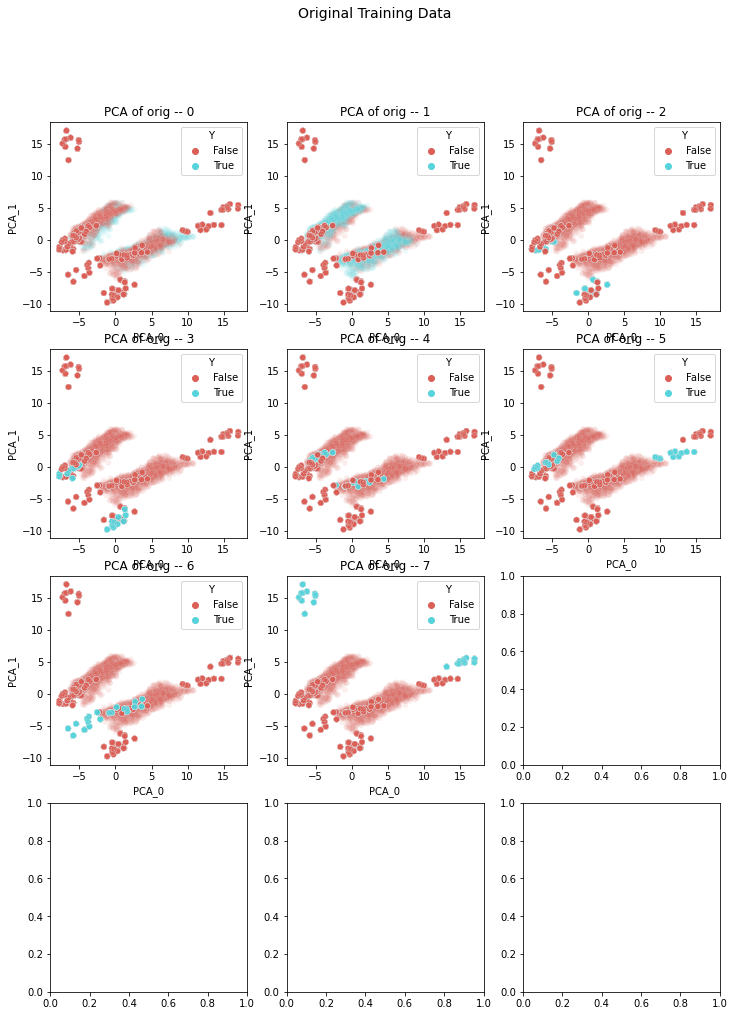

In [48]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(X_temp))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of orig -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of orig -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of orig -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of orig -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of orig -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of orig -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of orig -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of orig -- 7")


fig.suptitle("Original Training Data", fontsize=14)

fig.show()

(16000, 2)
(16000, 2)


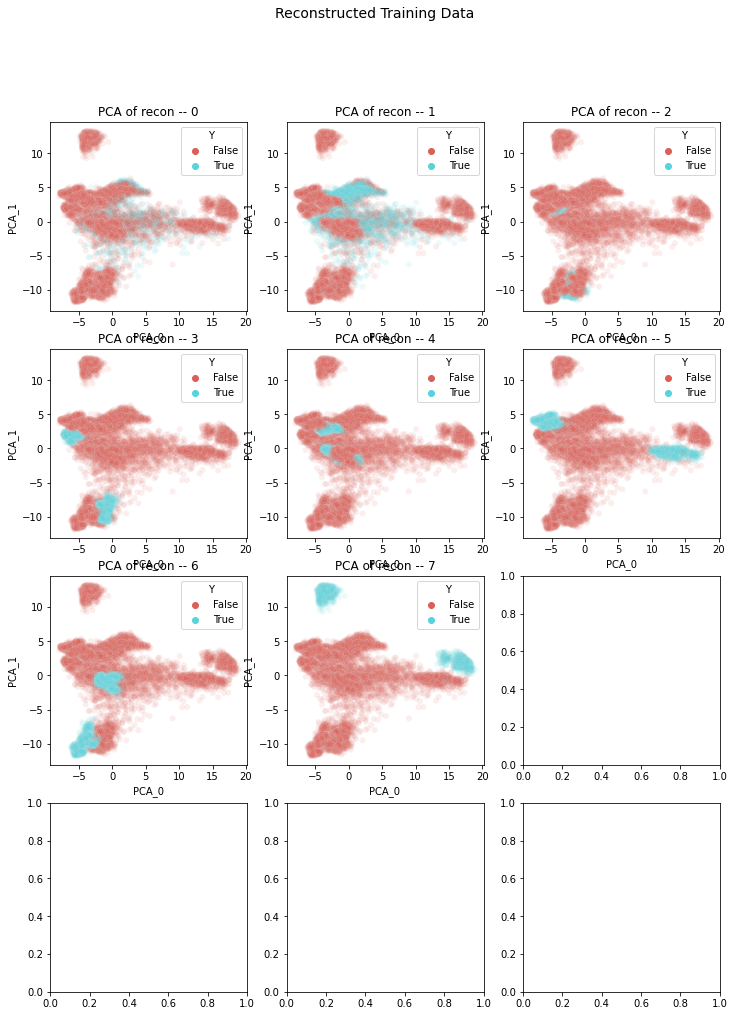

In [49]:

fig, axs = plt.subplots(4, 3, figsize=(12,16))

plot_df = get_pca_for_plotting(np.asarray(decoded_outputs))
plot_pca(plot_df, color_vec=label_temp==0, ax=axs[0,0], title="PCA of recon -- 0")
plot_pca(plot_df, color_vec=label_temp==1, ax=axs[0,1], title="PCA of recon -- 1")
plot_pca(plot_df, color_vec=label_temp==2, ax=axs[0,2], title="PCA of recon -- 2")
plot_pca(plot_df, color_vec=label_temp==3, ax=axs[1,0], title="PCA of recon -- 3")
plot_pca(plot_df, color_vec=label_temp==4, ax=axs[1,1], title="PCA of recon -- 4")
plot_pca(plot_df, color_vec=label_temp==5, ax=axs[1,2], title="PCA of recon -- 5")
plot_pca(plot_df, color_vec=label_temp==6, ax=axs[2,0], title="PCA of recon -- 6")
plot_pca(plot_df, color_vec=label_temp==7, ax=axs[2,1], title="PCA of recon -- 7")


fig.suptitle("Reconstructed Training Data", fontsize=14)

fig.show()

(32000, 2)
(32000, 2)


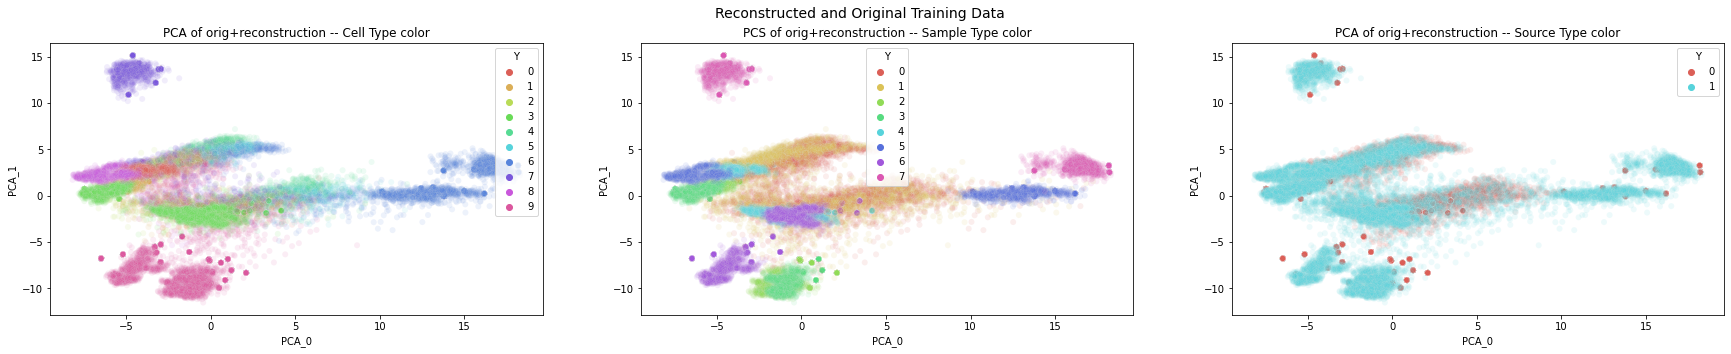

In [50]:
# make duplicated
X_dup = np.vstack([X_temp, decoded_outputs])


Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_dup = np.append(Y_temp, Y_temp)

label_dup = np.append(label_temp, label_temp)
perturb_dup = np.append(perturb_temp, perturb_temp)
source_dup = np.asarray(np.append([0]*16000, [1]*16000))

fig, axs = plt.subplots(1, 3, figsize=(30,5))

plot_df = get_pca_for_plotting(np.asarray(X_dup))
plot_pca(plot_df, color_vec=Y_dup, ax=axs[0], title="PCA of orig+reconstruction -- Cell Type color")
plot_pca(plot_df, color_vec=label_dup, ax=axs[1], title="PCS of orig+reconstruction -- Sample Type color")
plot_pca(plot_df, color_vec=source_dup, ax=axs[2], title="PCA of orig+reconstruction -- Source Type color")


fig.suptitle("Reconstructed and Original Training Data", fontsize=14)

fig.show()

### Plot latent spaces

Number unique Y: 7


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


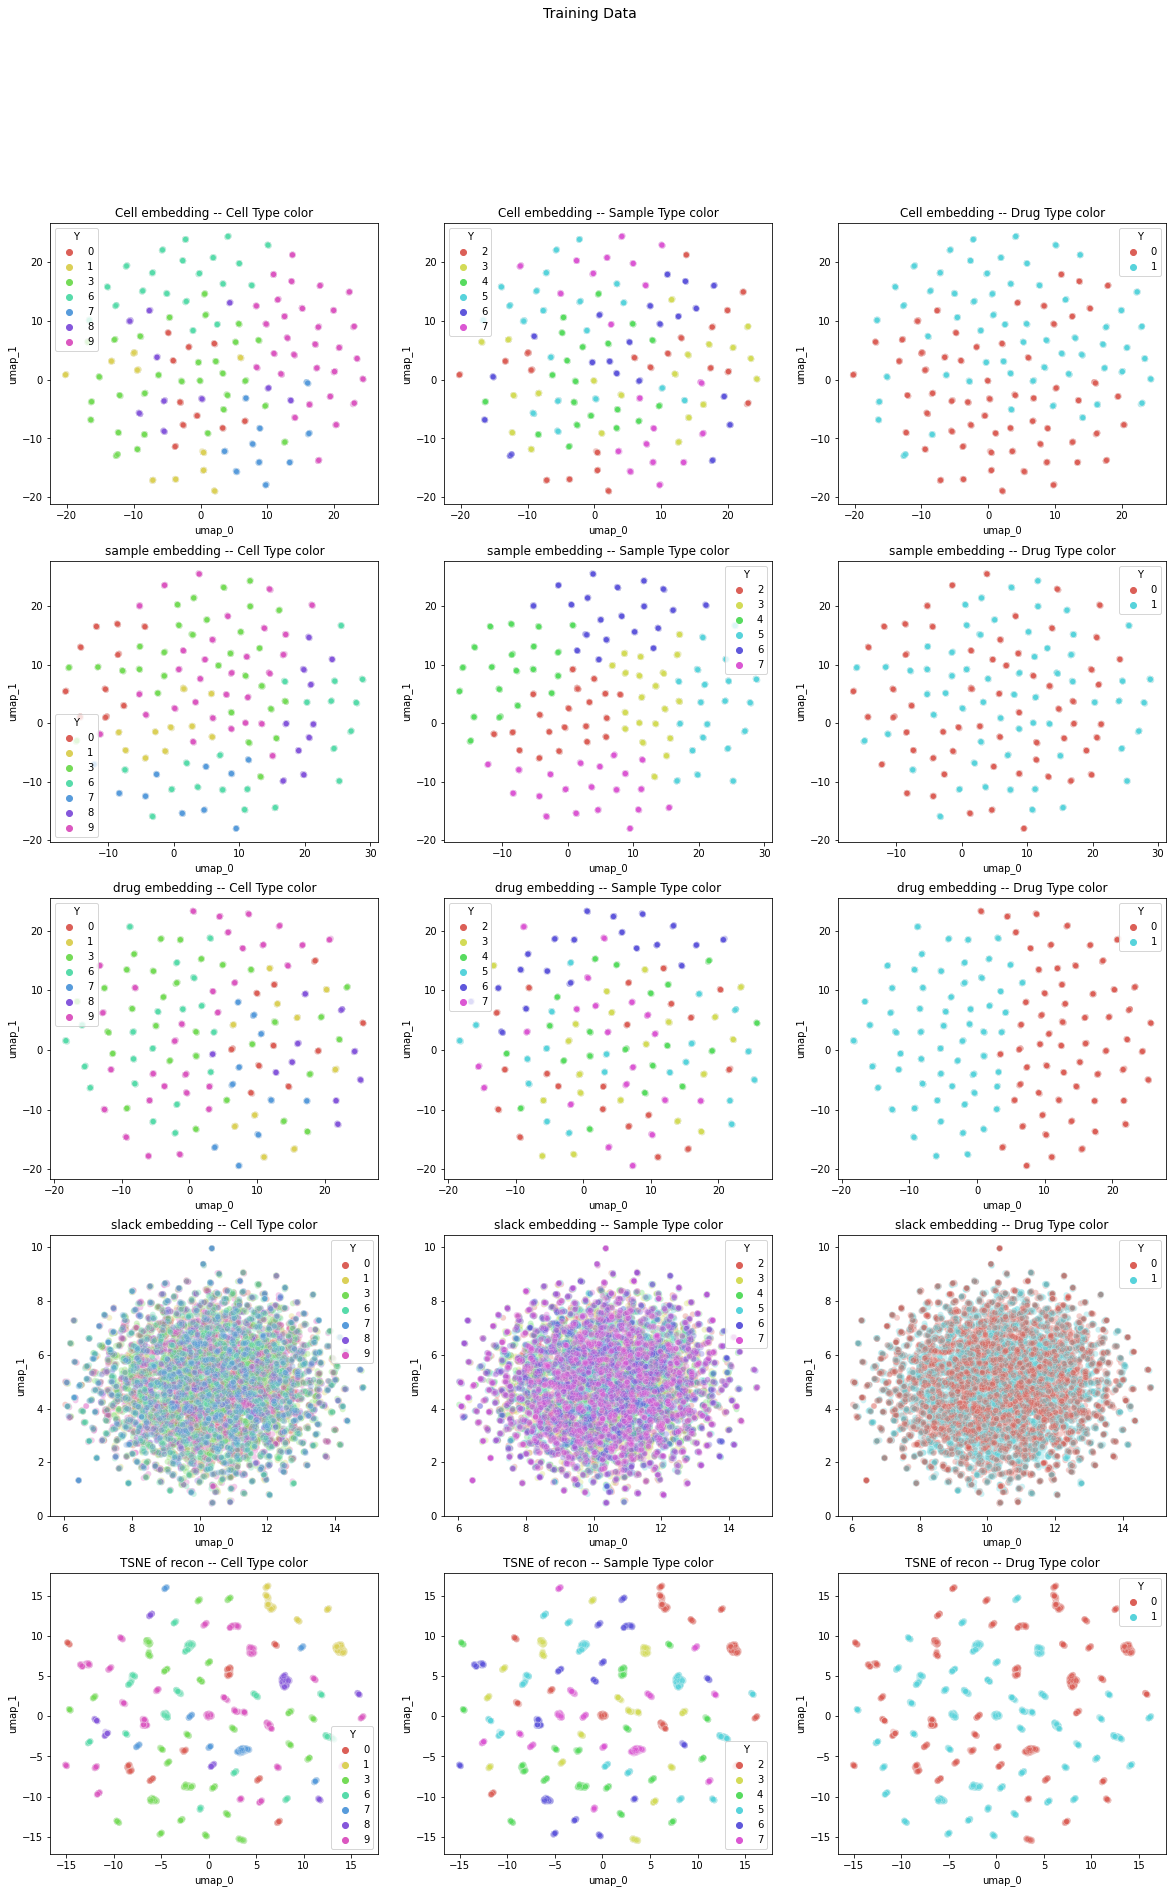

In [51]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = idx_unlab

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = get_umap_for_plotting(np.asarray(prop_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_rot))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_drug))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(mu_slack))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = get_umap_for_plotting(np.asarray(decoded_outputs))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
plot_umap(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


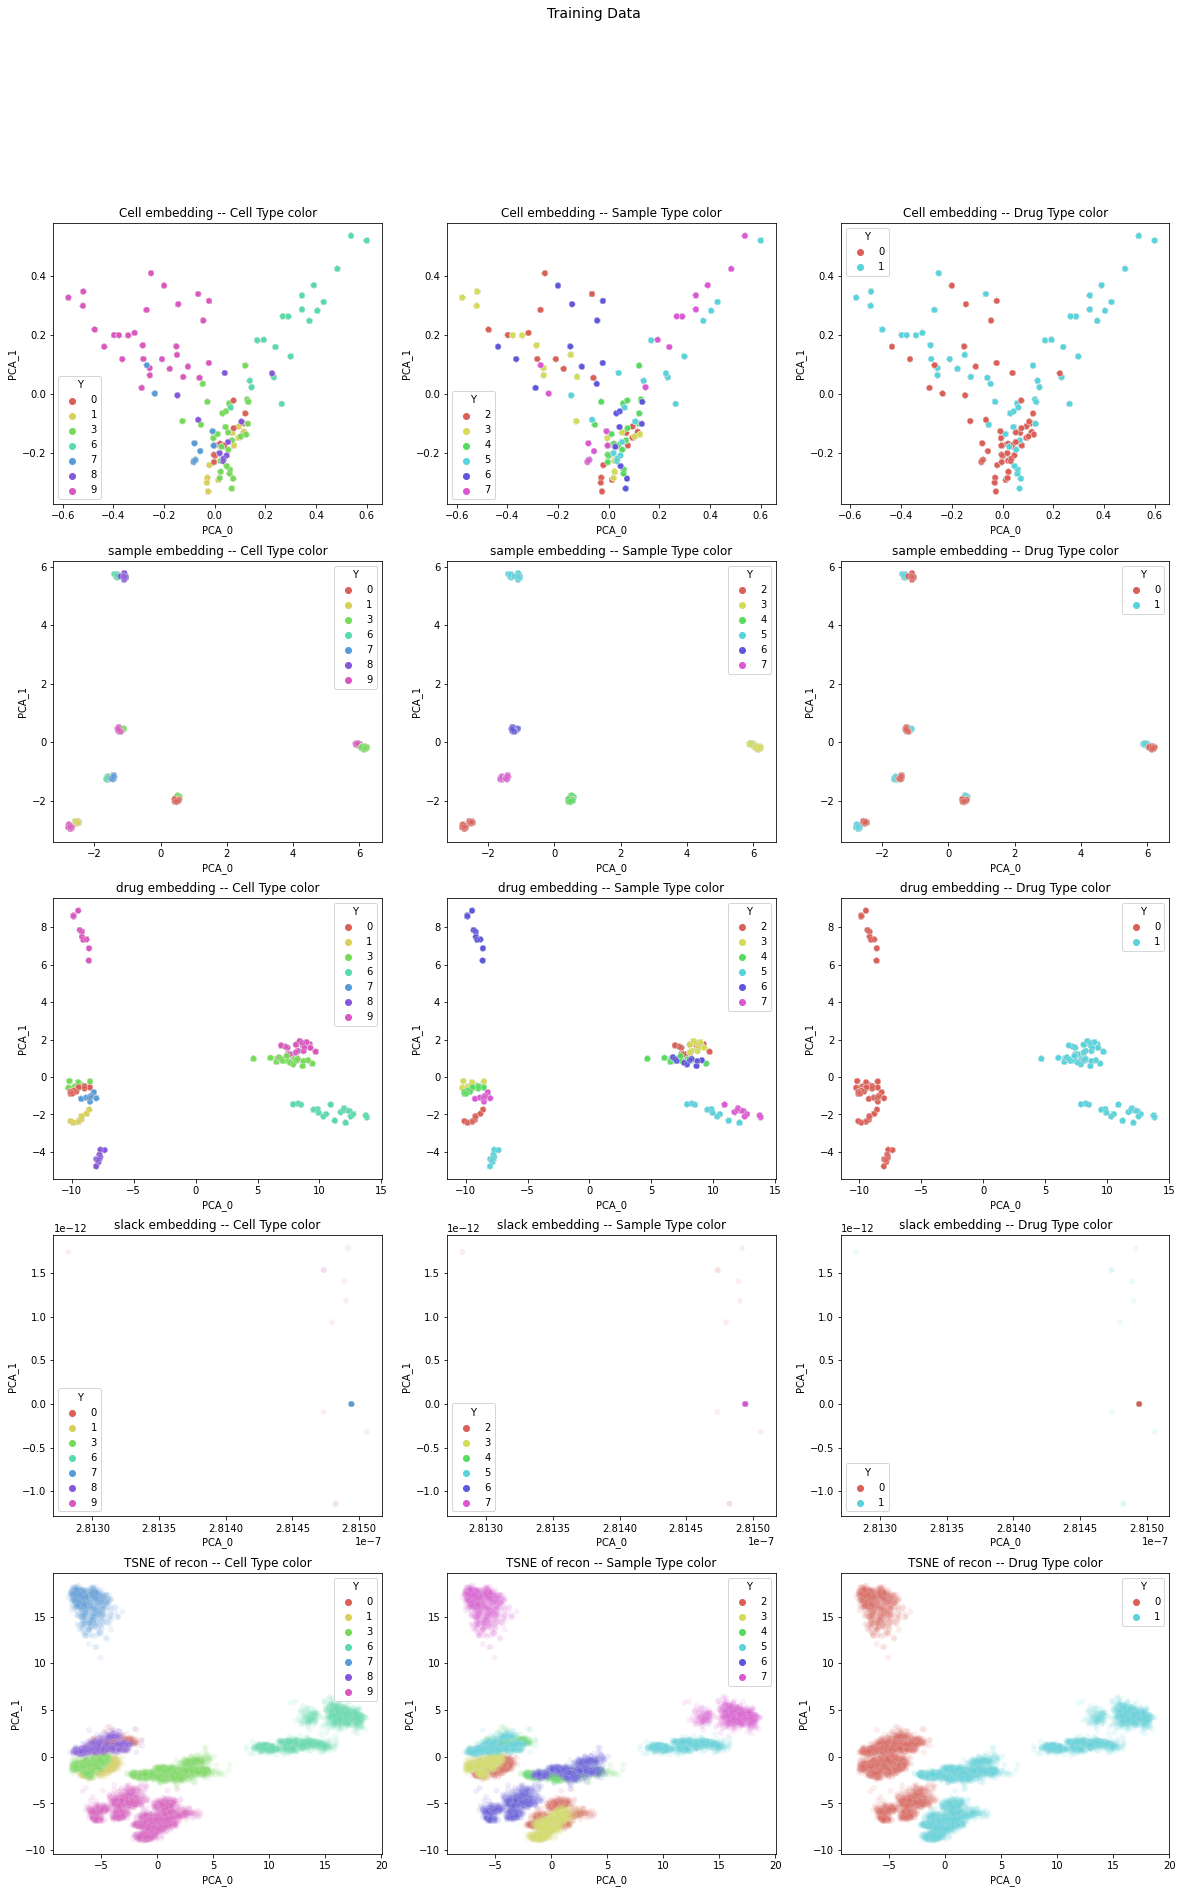

In [52]:
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = idx_unlab

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]

print(f"Number unique Y: {len(np.unique(Y_temp))}")


z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)
prop_outputs = classifier.predict(X_temp, batch_size=batch_size)


# now concatenate together
z_concat = np.hstack([z_slack, prop_outputs, z_rot, z_drug])

# and decode
decoded_outputs = decoder.predict(z_concat, batch_size=batch_size)


fig, axs = plt.subplots(5, 3, figsize=(20,30))

plot_df = get_pca_for_plotting(np.asarray(prop_outputs))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[0,2], title="Cell embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_rot))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[1,2], title="sample embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_drug))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[2,0], title="drug embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[2,1], title="drug embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[2,2], title="drug embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(mu_slack))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[3,0], title="slack embedding -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[3,1], title="slack embedding -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[3,2], title="slack embedding -- Drug Type color")

plot_df = get_pca_for_plotting(np.asarray(decoded_outputs))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[4,0], title="TSNE of recon -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[4,1], title="TSNE of recon -- Sample Type color")
plot_pca(plot_df, color_vec=perturb_temp, ax=axs[4,2], title="TSNE of recon -- Drug Type color")




fig.suptitle("Training Data", fontsize=14)

fig.show()

Number unique Y: 7
(12000, 2)
(12000, 2)


/tmp/ipykernel_16169/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_16169/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec
/tmp/ipykernel_16169/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

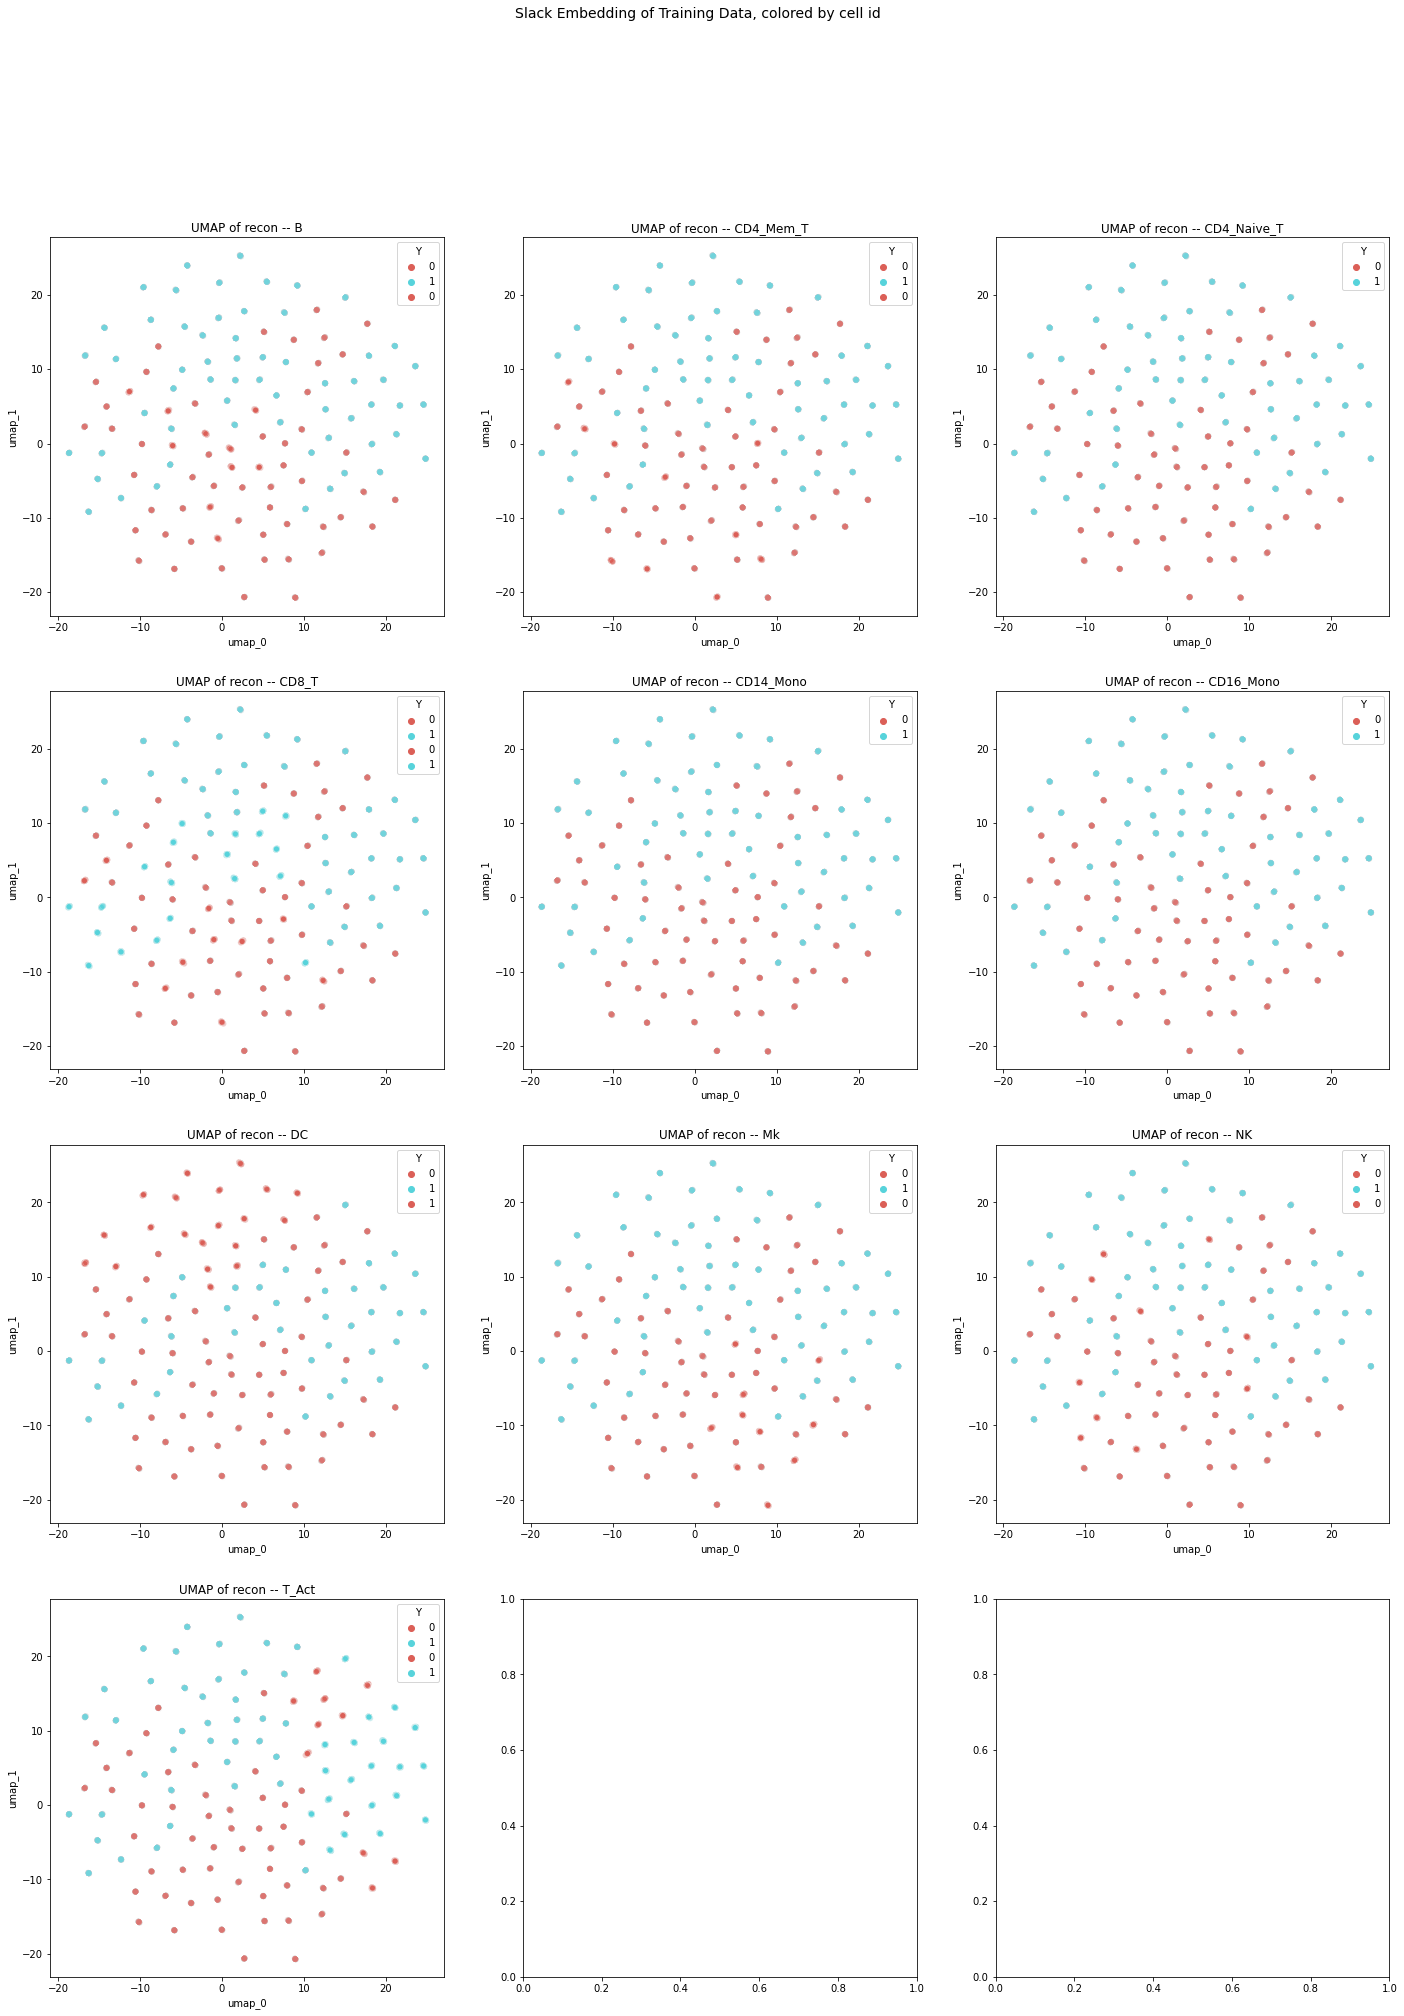

In [53]:

# plot proportions on labeled 10x and unlabeled 10x
# this is the training data

# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_tmp = idx_unlab

X_temp = np.copy(X_full)
X_temp = X_temp[idx_tmp,]

Y_temp = np.copy(Y_train)
Y_temp = np.argmax(Y_temp, axis=1)
Y_temp = Y_temp[idx_tmp]

label_temp = np.copy(Label_full)
label_temp = label_temp[idx_tmp]

perturb_temp =np.copy(Drug_full)
perturb_temp = perturb_temp[idx_tmp]


print(f"Number unique Y: {len(np.unique(Y_temp))}")

prop_outputs = classifier.predict(X_temp, batch_size=batch_size)

#z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot = pbmc6k_enc_unlab.predict(X_temp, batch_size=batch_size)

fig, axs = plt.subplots(4, 3, figsize=(24,32))

plot_df = get_umap_for_plotting(np.asarray(prop_outputs))

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,0], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 0)], color_vec=perturb_temp[np.where(Y_temp == 0)], ax=axs[0,0], title=f"UMAP of recon -- {Y_train.columns[0]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,1], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 1)], color_vec=perturb_temp[np.where(Y_temp == 1)], ax=axs[0,1], title=f"UMAP of recon -- {Y_train.columns[1]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[0,2], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 2)], color_vec=perturb_temp[np.where(Y_temp == 2)], ax=axs[0,2], title=f"UMAP of recon -- {Y_train.columns[2]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,0], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 3)], color_vec=perturb_temp[np.where(Y_temp == 3)], ax=axs[1,0], title=f"UMAP of recon -- {Y_train.columns[3]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,1], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 4)], color_vec=perturb_temp[np.where(Y_temp == 4)], ax=axs[1,1], title=f"UMAP of recon -- {Y_train.columns[4]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[1,2], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 5)], color_vec=perturb_temp[np.where(Y_temp == 5)], ax=axs[1,2], title=f"UMAP of recon -- {Y_train.columns[5]}")

plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,0], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 6)], color_vec=perturb_temp[np.where(Y_temp == 6)], ax=axs[2,0], title=f"UMAP of recon -- {Y_train.columns[6]}")


plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,1], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 7)], color_vec=perturb_temp[np.where(Y_temp == 7)], ax=axs[2,1], title=f"UMAP of recon -- {Y_train.columns[7]}")


plot_umap(plot_df, color_vec=perturb_temp, ax=axs[2,2], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 8)], color_vec=perturb_temp[np.where(Y_temp == 8)], ax=axs[2,2], title=f"UMAP of recon -- {Y_train.columns[8]}")


plot_umap(plot_df, color_vec=perturb_temp, ax=axs[3,0], alpha=0.01)
plot_umap(plot_df.iloc[np.where(Y_temp == 9)], color_vec=perturb_temp[np.where(Y_temp == 9)], ax=axs[3,0], title=f"UMAP of recon -- {Y_train.columns[9]}")

fig.suptitle("Slack Embedding of Training Data, colored by cell id", fontsize=14)

fig.show()

## Do latent space projectsions

In [54]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise():
    a = np.random.lognormal(mean=0, sigma=1, size=10) + np.array([0,0,0,0,0,100,0, 0, 0, 0])
    return a/a.sum()


### drug perturbation

In [55]:
Drug_full

array([1, 1, 1, ..., 0, 0, 0])

In [56]:
np.where(np.logical_and(perturb_temp == 1, np.logical_and(label_temp == 5, Y_temp == 5)))[0]

array([], dtype=int64)

In [57]:
# now we will take one cell type and project it across different sample IDs.
# this will allow us to see how well the reconstruction does
label_temp = np.copy(Label_full)
perturb_temp = np.copy(Drug_full)

X_temp = np.copy(X_orig)

prop_outputs = classifier.predict(X_temp, batch_size=batch_size)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)


# now use the encoder to get the latent spaces
z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

# first take all the samples from patient 0 where cell_4 is the max and not perturbed
label_temp = np.copy(Label_full)
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)
idx_0_patient = np.where(np.logical_and(perturb_temp == 0, np.logical_and(label_temp == 5, Y_temp == 5)))[0]

# and take a random set of the samples from patients with a perturbation 
# of the length of idx_0_patient
# this is because we will use this random sample as our translation
idx_1_patient = np.where(perturb_temp == 1)[0]
idx_1_patient = np.random.choice(idx_1_patient, len(idx_0_patient))

# now for patient 0, cell type 0
# we are shifting it to patient 1 cell type 0
# cell type should remain the same because the latent spaces are
# disentangled and we are not changing Y
z_drug_perturb = np.copy(z_drug)
z_drug_perturb[idx_0_patient,] = z_drug_perturb[idx_1_patient,]

# now concatenate together and decode
z_concat_unlab_perturb = np.hstack([z_slack, prop_outputs, z_rot, z_drug_perturb])
decoded_0_1 = decoder.predict(z_concat_unlab_perturb, batch_size=batch_size)
decoded_0_1 = scaler.inverse_transform(decoded_0_1)


# compare with original
z_concat_unlab_UNperturb = np.hstack([z_slack, prop_outputs, z_rot, z_drug])
decoded_0_0 = decoder.predict(z_concat_unlab_UNperturb, batch_size=batch_size)
decoded_0_0 = scaler.inverse_transform(decoded_0_0)




(16000, 2)
(16000, 2)


/tmp/ipykernel_16169/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(16000, 2)
(16000, 2)


/tmp/ipykernel_16169/563184163.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


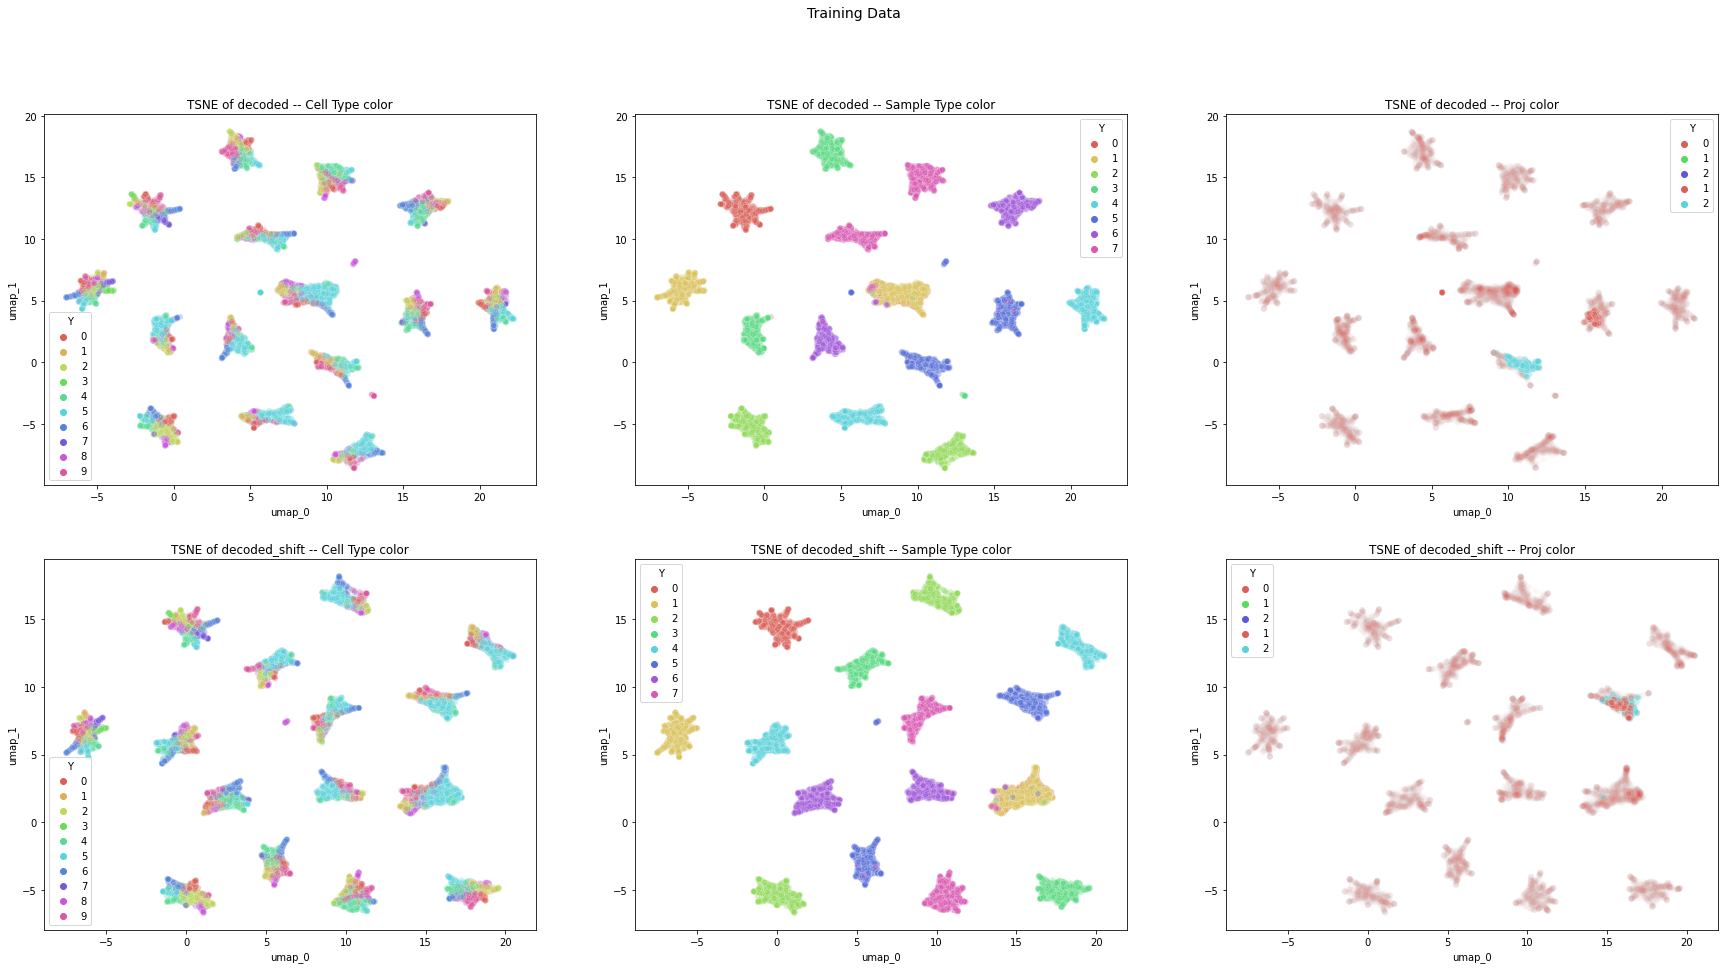

In [58]:
# Plot all patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 5, label_temp == 5)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 5, label_temp == 5)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

plot_df = get_umap_for_plotting(np.asarray(decoded_0_0))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1))
plot_umap(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_umap(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(16000, 2)
(16000, 2)


/tmp/ipykernel_16169/4280157301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


(16000, 2)
(16000, 2)


/tmp/ipykernel_16169/4280157301.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Y'] = color_vec


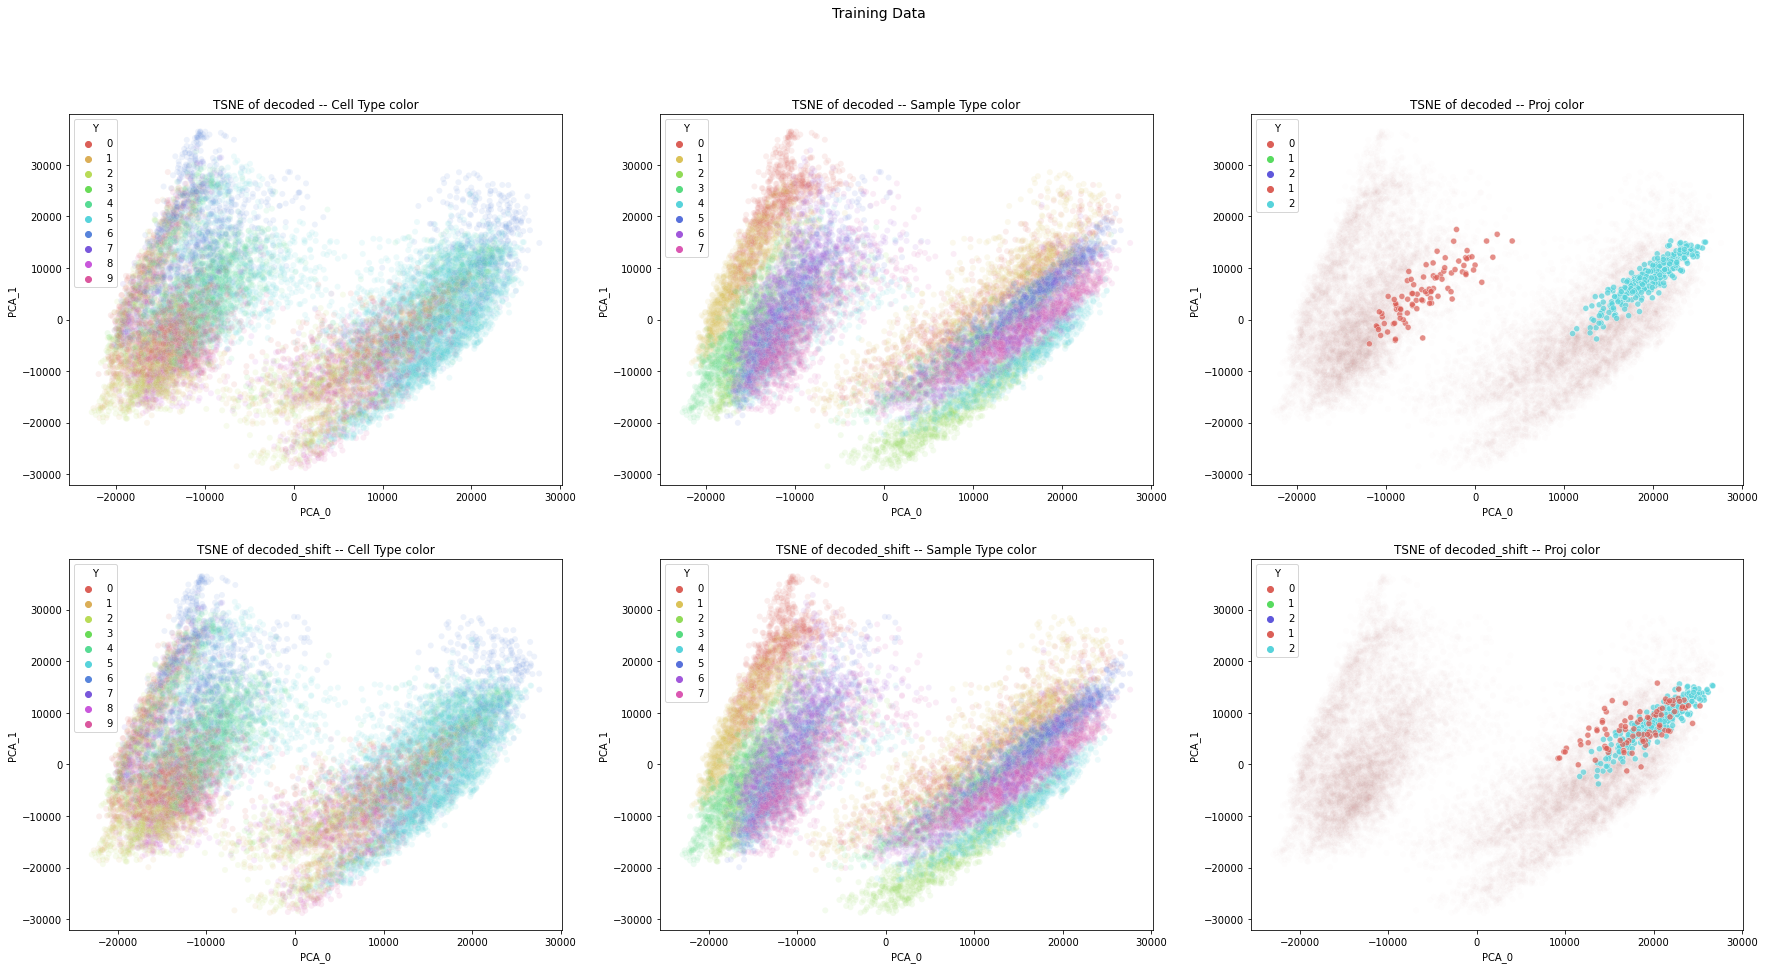

In [59]:
# Plot all patients

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)

idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 5, label_temp == 5)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 5, label_temp == 5)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 samp 0"
proj_temp[idx_reg_cell0] = 2 #"cell0 samp 1"


only_cell_0_interest = np.union1d(idx_proj_cell0, idx_reg_cell0)

fig, axs = plt.subplots(2, 3, figsize=(30,15))

plot_df = get_pca_for_plotting(np.asarray(decoded_0_0))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_pca(plot_df, color_vec=proj_temp, ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.01)
plot_pca(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.7)

plot_df = get_pca_for_plotting(np.asarray(decoded_0_1))
plot_pca(plot_df, color_vec=Y_temp, ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_pca(plot_df, color_vec=label_temp, ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_pca(plot_df, color_vec=proj_temp, ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.01)
plot_pca(plot_df.iloc[only_cell_0_interest], color_vec=proj_temp[only_cell_0_interest], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.7)


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


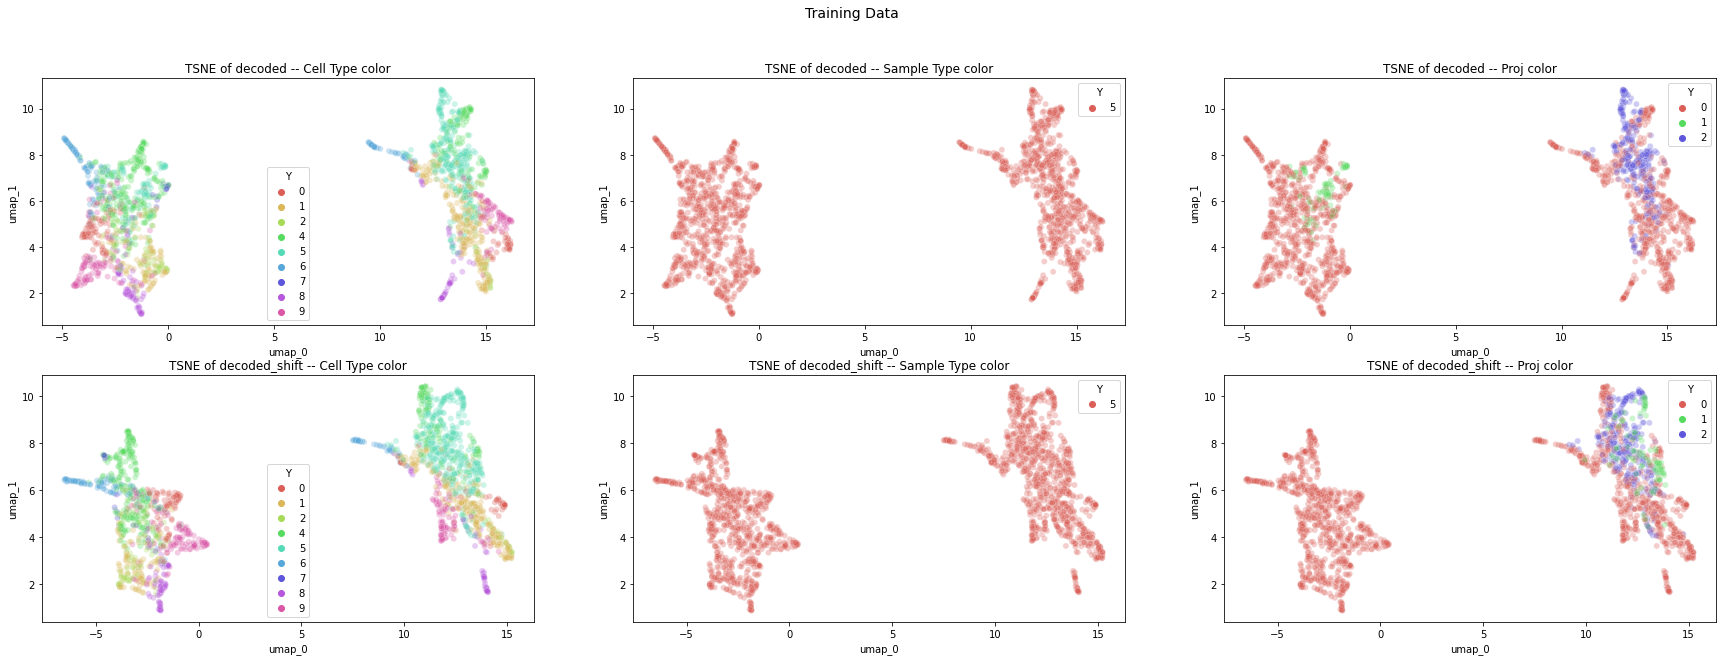

In [60]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 5, label_temp == 5)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 5, label_temp == 5)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(10000, 12000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_umap_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color")

plot_df = get_umap_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_umap(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color")
plot_umap(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color")
plot_umap(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color")


fig.suptitle("Training Data", fontsize=14)

fig.show()



(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


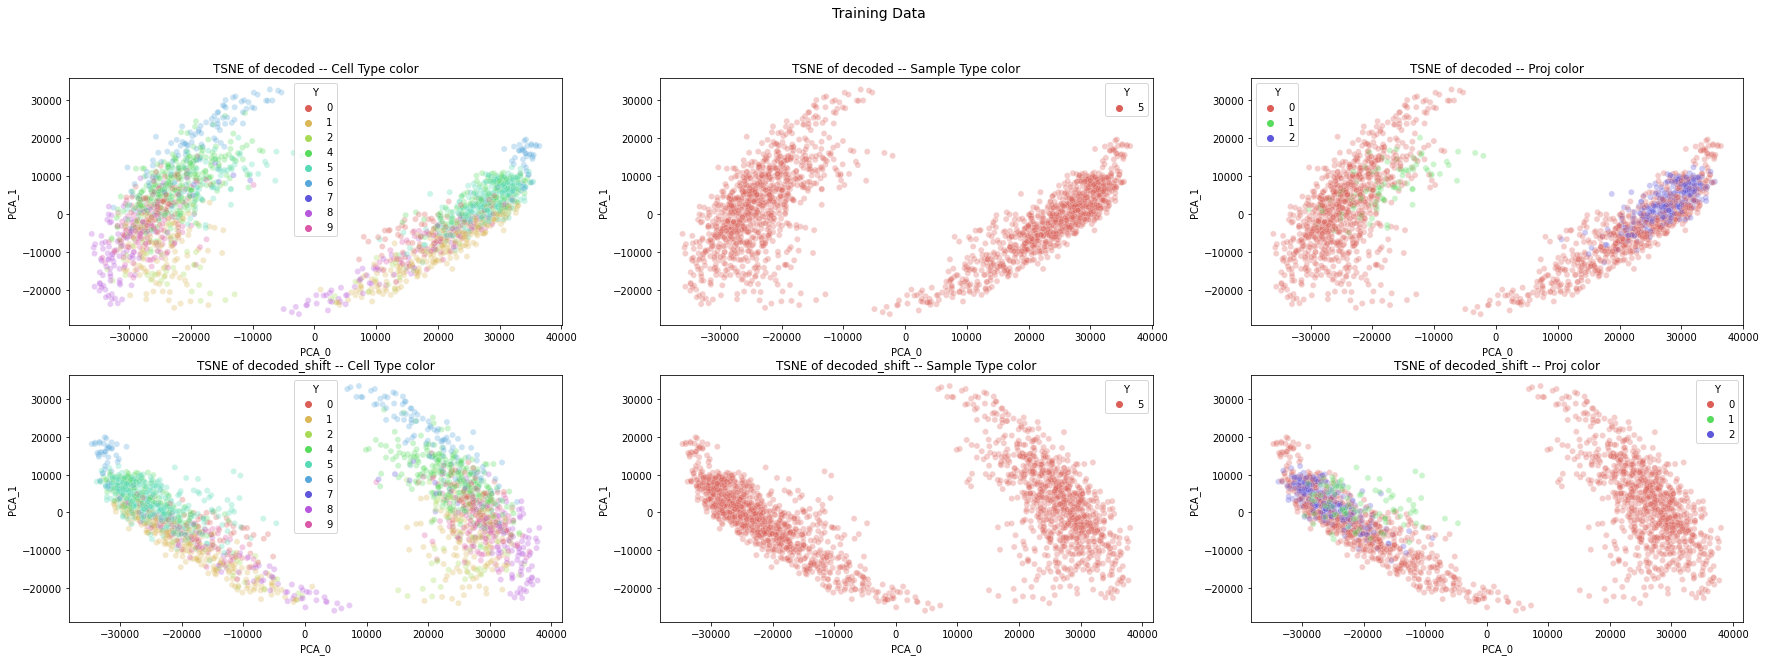

In [61]:
# Plot patient of interest

label_temp = np.copy(Label_full)
perturb_temp = Drug_full
Y_temp = np.copy(prop_outputs)
Y_temp = np.argmax(Y_temp, axis=1)

proj_temp = np.array([0]*len(Y_temp)) # ["other"]*len(Y_temp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 5, label_temp == 5)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 5, label_temp == 5)))[0]

proj_temp[idx_proj_cell0] = 1 #"cell0 projected to samp 1"
proj_temp[idx_reg_cell0] = 2 #"cell0 already in samp 1"


samp_0 = range(10000, 12000)

fig, axs = plt.subplots(2, 3, figsize=(30,10))


plot_df = get_pca_for_plotting(np.asarray(decoded_0_0[samp_0,]))
plot_pca(plot_df, color_vec=Y_temp[samp_0], ax=axs[0,0], title="TSNE of decoded -- Cell Type color", alpha=0.3)
plot_pca(plot_df, color_vec=label_temp[samp_0], ax=axs[0,1], title="TSNE of decoded -- Sample Type color", alpha=0.3)
plot_pca(plot_df, color_vec=proj_temp[samp_0], ax=axs[0,2], title="TSNE of decoded -- Proj color", alpha=0.3)

plot_df = get_pca_for_plotting(np.asarray(decoded_0_1[samp_0,]))
plot_pca(plot_df, color_vec=Y_temp[samp_0], ax=axs[1,0], title="TSNE of decoded_shift -- Cell Type color", alpha=0.3)
plot_pca(plot_df, color_vec=label_temp[samp_0], ax=axs[1,1], title="TSNE of decoded_shift -- Sample Type color", alpha=0.3)
plot_pca(plot_df, color_vec=proj_temp[samp_0], ax=axs[1,2], title="TSNE of decoded_shift -- Proj color", alpha=0.3)


fig.suptitle("Training Data", fontsize=14)

fig.show()



In [62]:
def plot_expr_corr(xval, yval, ax, title, xlab, ylab, class_id, max_val=2700):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax,
        hue=class_id,
        alpha=0.5
    )
    g.set(ylim=(0, max_val))
    g.set(xlim=(0, max_val))
    g.plot([0, max_val], [0, max_val], transform=g.transAxes)


    ax.set_title(title)
    return g


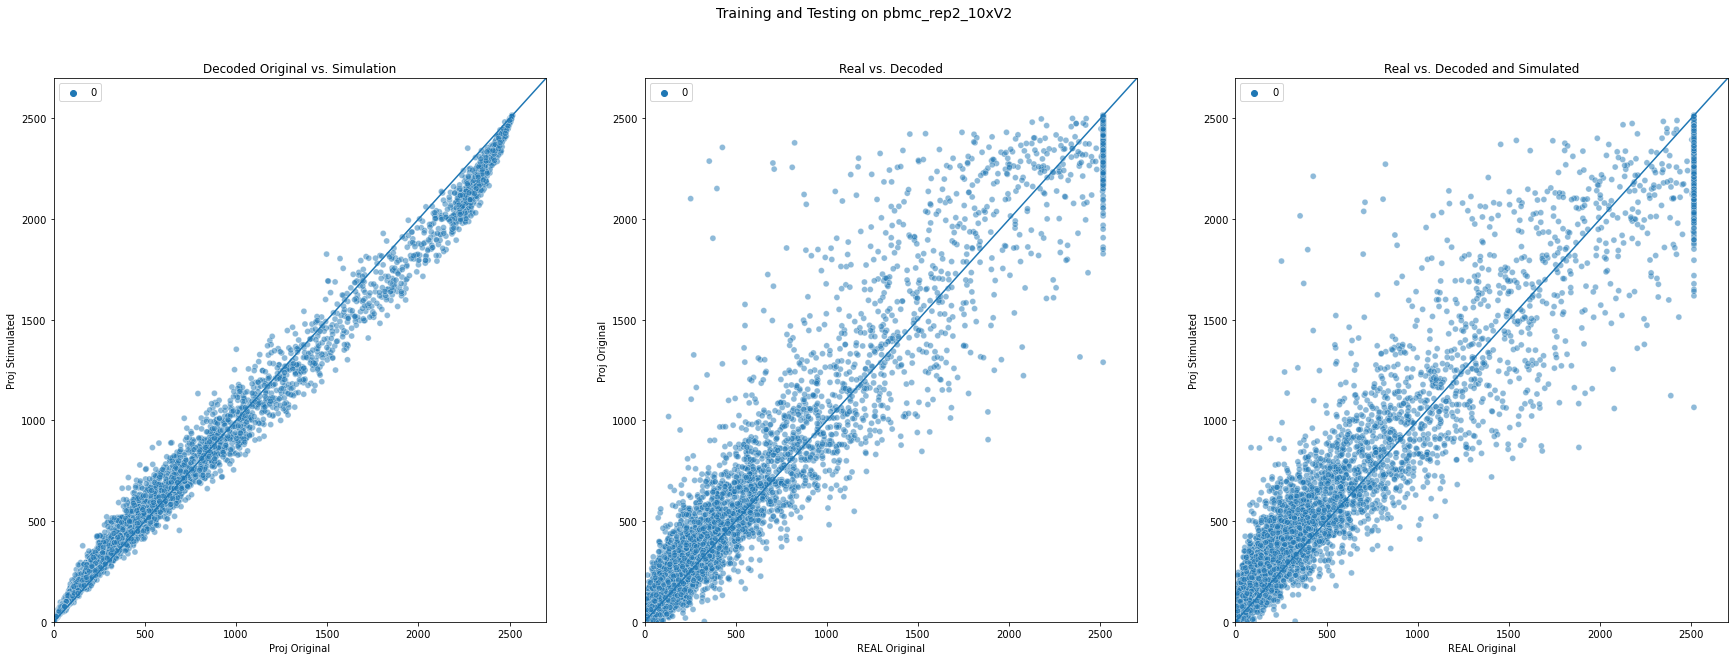

In [63]:
X_tmp = X_orig
X_tmp = scaler.inverse_transform(X_tmp)


idx_proj_cell0 = np.where(np.logical_and(perturb_temp == 0, np.logical_and(Y_temp == 5, label_temp == 5)))[0]
idx_reg_cell0 = np.where(np.logical_and(perturb_temp == 1, np.logical_and(Y_temp == 5, label_temp == 5)))[0]

projected_original = decoded_0_1[idx_reg_cell0,]
real_original = X_tmp[idx_reg_cell0,]
projected_simulated = decoded_0_1[idx_proj_cell0,]

projected_original = np.median(projected_original, axis=0)
real_original = np.median(real_original, axis=0)
projected_simulated = np.median(projected_simulated, axis=0)

class_color = [0]*len(projected_original)

fig, axs = plt.subplots(1, 3, figsize=(30,10))

plot_expr_corr(projected_original, projected_simulated, axs[0], title="Decoded Original vs. Simulation", xlab="Proj Original", ylab="Proj Stimulated", class_id=class_color)
plot_expr_corr(real_original, projected_original, axs[1], title="Real vs. Decoded", xlab="REAL Original", ylab="Proj Original", class_id=class_color)
plot_expr_corr(real_original, projected_simulated, axs[2], title="Real vs. Decoded and Simulated", xlab="REAL Original", ylab="Proj Stimulated", class_id=class_color)


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

In [64]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(real_original, projected_simulated)
coefficient_of_dermination

0.9373754011100242

## Compare gene expression between sim and non

In [65]:
# this is to generate noisy vector where the second elements is the largest
def add_vec_noise_idx(idx):
    in_vec =  np.array([0,0,0,0,0,0,0, 0, 0, 0])
    in_vec[idx] = 1000
    a = np.random.lognormal(mean=0, sigma=1, size=10) + in_vec
    return a/a.sum()


In [66]:
np.unique(label_temp)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [67]:
# simulate cell type specific perturbation effects


label_temp = np.copy(Label_full)
perturb_temp = np.copy(Drug_full)

X_temp = np.copy(X_orig)
X_invs = np.copy(X_orig)
X_invs = scaler.inverse_transform(X_invs)

# make num_samp_gen samples per sample_id
num_samp_gen = 100

all_res = [0]*Y_train.shape[1]

deseq_matr = None

for cell_idx in range(Y_train.shape[1]):

    curr_deseq_matr_0 = None
    curr_deseq_matr_1 = None

    for samp_idx in np.unique(label_temp):

        # now use the encoder to get the latent spaces
        z_slack, mu_slack, l_sigma_slack, z_rot, mu_rot, l_sigma_rot, z_drug, mu_drug, l_sigma_drug = encoder_unlab.predict(X_temp, batch_size=batch_size)

        # simulate 1 cell type
        noisy_prop_vec = [add_vec_noise_idx(cell_idx) for i in range(num_samp_gen)]
        noisy_prop_vec = np.vstack(noisy_prop_vec)

        # randomly sample the sample_ids (integrating over all latent codes)
        z_rot_samp_idx = np.where(np.logical_and(perturb_temp == 0, label_temp == samp_idx))[0]

        if z_rot_samp_idx.shape[0] == 0:
            continue
        
        z_rot_samp_idx = np.random.choice(z_rot_samp_idx, num_samp_gen)
        z_rot_samp_idx = np.sort(z_rot_samp_idx)
        z_rot_samp = z_rot[z_rot_samp_idx,]

        # randomly sample the slack (integrating over all latent codes)
        z_slack_samp_idx = np.sort(np.random.choice(range(z_slack.shape[0]), num_samp_gen))
        z_slack_samp = z_slack[z_slack_samp_idx,]

        # sample the the perturbed latent space
        z_drug_0_idx = np.random.choice(np.where(perturb_temp == 0)[0], num_samp_gen)
        z_drug_0_idx = np.sort(z_drug_0_idx)
        z_drug_0 = z_drug[z_drug_0_idx,]

        z_drug_1_idx = np.random.choice(np.where(perturb_temp == 1)[0], num_samp_gen)
        z_drug_1_idx = np.sort(z_drug_1_idx)
        z_drug_1 = z_drug[z_drug_1_idx,]


        # put it all together

        # generate unperturbed data -- integrated over all other latent spaces
        z_concat_UNperturb = np.hstack([z_slack_samp, noisy_prop_vec, z_rot_samp, z_drug_0])
        decoded_0 = decoder.predict(z_concat_UNperturb, batch_size=batch_size)
        decoded_0 = scaler.inverse_transform(decoded_0)

        if curr_deseq_matr_0 is None:
            curr_deseq_matr_0 = decoded_0
        else:
            curr_deseq_matr_0 = np.vstack([curr_deseq_matr_0, decoded_0])



        # generate unperturbed data -- integrated over all other latent spaces
        z_concat_perturb = np.hstack([z_slack_samp, noisy_prop_vec, z_rot_samp, z_drug_1])
        decoded_1 = decoder.predict(z_concat_perturb, batch_size=batch_size)
        decoded_1 = scaler.inverse_transform(decoded_1)

        if curr_deseq_matr_1 is None:
            curr_deseq_matr_1 = decoded_1
        else:
            curr_deseq_matr_1 = np.vstack([curr_deseq_matr_1, decoded_1])

    # format the median diff 
    #decoded_0_med = np.median(curr_deseq_matr_0, axis=0)
    #decoded_1_med = np.median(curr_deseq_matr_1, axis=0)

    #res_df = pd.DataFrame(list(zip(decoded_0_med, decoded_1_med)), columns=["unpert", "pert"])
    decoded_med = np.median(curr_deseq_matr_1/curr_deseq_matr_0, axis=0)
    res_df = pd.DataFrame(decoded_med, columns=["FC"])

    res_df["log2FC"] = np.log2(res_df.FC)
    res_df["abslog2FC"] = np.absolute(res_df.log2FC)
    res_df["gene_ids"] = union_genes
    res_df.set_index("gene_ids", inplace = True)

    all_res[cell_idx] = res_df

    # format the deseq table
    curr_deseq_matr_0 = pd.DataFrame(curr_deseq_matr_0, columns=union_genes)
    curr_deseq_matr_0['CellType'] = Y_train.columns[cell_idx]
    curr_deseq_matr_0['SampleID'] = np.repeat([0,1,2,3,4,5,6,7], num_samp_gen)
    curr_deseq_matr_0['Perturbed'] = 0

    curr_deseq_matr_1 = pd.DataFrame(curr_deseq_matr_1, columns=union_genes)
    curr_deseq_matr_1['CellType'] = Y_train.columns[cell_idx]
    curr_deseq_matr_1['SampleID'] = np.repeat([0,1,2,3,4,5,6,7], num_samp_gen)
    curr_deseq_matr_1['Perturbed'] = 1

    curr_deseq_matr = pd.concat([curr_deseq_matr_0, curr_deseq_matr_1])

    if deseq_matr is None:
        deseq_matr = curr_deseq_matr
    else:
        deseq_matr = pd.concat([deseq_matr, curr_deseq_matr])


        


In [68]:
deseq_matr

A1BG        A2M   A2M-AS1     A4GALT        AAED1       AAGAB  \
0    177.323425  37.873970  0.611801  38.811554  1375.978149  161.675156   
1    276.812988  59.853439  2.918226  64.348061  1292.653687  178.179092   
2    243.264771  46.716309  0.728461  42.730164  1602.937866  144.111221   
3    312.072510  72.441849  3.733164  65.229660  1365.140991  261.926453   
4    185.698807  83.113853  1.000638  54.671204  1631.949951  161.590454   
..          ...        ...       ...        ...          ...         ...   
795   13.709024  40.683727  0.058955   0.149583  1840.555908  856.053467   
796    4.322605  46.710312  0.153410   0.413590  1743.598877  989.211487   
797    9.928329  41.697464  0.421144   0.712427  1395.640137  854.965759   
798   12.836123  71.731819  0.218096   0.781983  1768.270630  950.129517   
799    4.347265  34.681129  0.258546   0.412465  1644.557129  642.740112   

           AAK1         AAMP      AARSD1       AASDH  ...     ZSWIM4  \
0     68.097878  1347.185303   45.976521    7.163692  ...  19.379507   
1     84.590355  1230.646240   67.620956   26.139954  ...  36.042572   
2     55.699703  1262.857178   32.040916   12.913850  ...  18.852139   
3    119.502411  1400.917603   74.647034   36.082973  ...  36.863605   
4     58.448299  1608.231934   45.691177   12.437599  ...  24.211042   
..          ...          ...         ...         ...  ...        ...   
795  107.778061   945.314270  873.799622   75.657173  ...   0.637399   
796   68.513870   885.716492  672.021606  114.278572  ...   2.279166   
797   96.263954   776.760620  640.225586  130.807693  ...   7.475496   
798   70.389114   992.684143  731.714539  224.344193  ...   3.818023   
799   83.694893   722.652283  555.305115  106.009628  ...   7.088965   

           ZUFSP      ZWILCH          ZYX      ZZEF1        ZZZ3  \
0      13.722141   70.129700   264.113586  21.570679   31.043818   
1      25.042343   90.658157   264.971039  46.888397   40.990360   
2       9.457549   69.199158   227.365921  22.929274   11.623237   
3      35.362526   86.107620   245.709656  56.015255   46.833458   
4      10.675833   65.527145   363.157898  37.590347   18.993574   
..           ...         ...          ...        ...         ...   
795  2163.416748   95.663658  1028.588135  16.814322  493.256409   
796  2286.594727  106.049652  1071.127441  25.457283  538.018555   
797  2229.676025  127.149323   941.625671  46.217869  412.394592   
798  2327.018555  106.883949  1573.930176  27.421122  495.511719   
799  2253.403076   96.649216   977.459595  40.817444  271.132751   

     hsa-mir-1199  CellType  SampleID  Perturbed  
0        4.462992         B         0          0  
1       10.716457         B         0          0  
2        3.551341         B         0          0  
3       10.598782         B         0          0  
4        5.276155         B         0          0  
..            ...       ...       ...        ...  
795     15.423571     T_Act         7          1  
796     16.062319     T_Act         7          1  
797     26.155094     T_Act         7          1  
798     22.319757     T_Act         7          1  
799     14.030722     T_Act         7          1  

[16000 rows x 7024 columns]

In [69]:
""" 
class_color = [0]*len(decoded_0_med)

fig, axs = plt.subplots(10, 2, figsize=(15,60))
row_idx = 0
for cell_idx in range(Y_train.shape[1]):

    curr_cell_type = Y_train.columns[cell_idx]
    curr_res = all_res[cell_idx]

    unpert_val = curr_res["unpert"]
    pert_val = curr_res["pert"]

    max_val_log2 = np.max([np.log2(unpert_val), np.log2(unpert_val)])
    max_val = np.max([unpert_val, pert_val])
    plot_expr_corr(np.log2(unpert_val), np.log2(pert_val), axs[row_idx,0], title=f"{curr_cell_type} log2 Perturbed vs. unperturbed", xlab="non-perturbed", ylab="perturbed", class_id=class_color, max_val = max_val_log2)
    plot_expr_corr(unpert_val, pert_val, axs[row_idx,1], title=f"{curr_cell_type} Perturbed vs. unperturbed", xlab="non-perturbed", ylab="perturbed", class_id=class_color, max_val = max_val)

    row_idx = row_idx+1

fig.suptitle("Integrated over Perturb vs nonPerturb", fontsize=14)

fig.show()
 """

' \nclass_color = [0]*len(decoded_0_med)\n\nfig, axs = plt.subplots(10, 2, figsize=(15,60))\nrow_idx = 0\nfor cell_idx in range(Y_train.shape[1]):\n\n    curr_cell_type = Y_train.columns[cell_idx]\n    curr_res = all_res[cell_idx]\n\n    unpert_val = curr_res["unpert"]\n    pert_val = curr_res["pert"]\n\n    max_val_log2 = np.max([np.log2(unpert_val), np.log2(unpert_val)])\n    max_val = np.max([unpert_val, pert_val])\n    plot_expr_corr(np.log2(unpert_val), np.log2(pert_val), axs[row_idx,0], title=f"{curr_cell_type} log2 Perturbed vs. unperturbed", xlab="non-perturbed", ylab="perturbed", class_id=class_color, max_val = max_val_log2)\n    plot_expr_corr(unpert_val, pert_val, axs[row_idx,1], title=f"{curr_cell_type} Perturbed vs. unperturbed", xlab="non-perturbed", ylab="perturbed", class_id=class_color, max_val = max_val)\n\n    row_idx = row_idx+1\n\nfig.suptitle("Integrated over Perturb vs nonPerturb", fontsize=14)\n\nfig.show()\n '

In [70]:
""" class_color = [0]*num_samp_gen+[1]*num_samp_gen
full_matr_sim = np.vstack((decoded_0, decoded_1))

fig, axs = plt.subplots(1, 2, figsize=(30,10))


plot_df_umap = get_umap_for_plotting(np.asarray(full_matr_sim))
plot_umap(plot_df_umap, color_vec=class_color, ax=axs[0], title="UMAP of decoded -- Sample Type color")


plot_df_pca = get_pca_for_plotting(np.asarray(full_matr_sim))
plot_pca(plot_df_pca, color_vec=class_color, ax=axs[1], title="PCA of decoded -- Sample Type color")


fig.suptitle("Training Data", fontsize=14)

fig.show()
 """

' class_color = [0]*num_samp_gen+[1]*num_samp_gen\nfull_matr_sim = np.vstack((decoded_0, decoded_1))\n\nfig, axs = plt.subplots(1, 2, figsize=(30,10))\n\n\nplot_df_umap = get_umap_for_plotting(np.asarray(full_matr_sim))\nplot_umap(plot_df_umap, color_vec=class_color, ax=axs[0], title="UMAP of decoded -- Sample Type color")\n\n\nplot_df_pca = get_pca_for_plotting(np.asarray(full_matr_sim))\nplot_pca(plot_df_pca, color_vec=class_color, ax=axs[1], title="PCA of decoded -- Sample Type color")\n\n\nfig.suptitle("Training Data", fontsize=14)\n\nfig.show()\n '

In [71]:
top_genes = {}

for cell_idx in range(Y_train.shape[1]):

    a = all_res[cell_idx]
    a = a.iloc[np.where(np.logical_or(a.log2FC < -2, a.log2FC > 2))]
    top_genes[Y_train.columns[cell_idx]] = a.index.to_list()


In [72]:
idx = 0
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

B


Index(['AC084018.1', 'ANXA3', 'APOBEC3A', 'CCDC146', 'CCL8', 'CKB', 'CLEC4C',
       'CMPK2', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL9', 'CYP19A1', 'DDX60',
       'ELOVL3', 'EXOC2', 'EXOC3L1', 'FUT4', 'GMPR', 'HAPLN3', 'HERC5',
       'HESX1', 'HRASLS2', 'IFI27', 'IFIT1', 'IL1RN', 'IL27', 'LAG3', 'LPIN2',
       'MED13', 'MNDA', 'NEXN', 'OAS1', 'OAS3', 'PARP9', 'PDGFRL', 'RSAD2',
       'RTP4', 'SAMD4A', 'SAMD9L', 'SCIN', 'SCT', 'SIGLEC1', 'SOBP', 'STAT2',
       'TARBP1', 'TGM1'],
      dtype='object', name='gene_ids')

In [73]:
idx = 1
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

CD4_Mem_T


Index(['ANXA3', 'APOBEC3A', 'CCDC146', 'CCL8', 'CXCL10', 'CXCL11', 'CXCL13',
       'CXCL9', 'DDX60', 'ETV7', 'EXOC2', 'EXOC3L1', 'HESX1', 'HRASLS2',
       'IDO1', 'IFIT1', 'IFIT3', 'IL1RN', 'IL27', 'LAP3', 'PRF1', 'RSAD2',
       'RTP4', 'SAMD9L', 'SOBP', 'TREX1'],
      dtype='object', name='gene_ids')

In [74]:
idx = 2
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

CD4_Naive_T


Index(['ANXA3', 'APOBEC3A', 'CCDC146', 'CCL7', 'CCL8', 'CCNA1', 'CMPK2',
       'CXCL10', 'CXCL11', 'CXCL13', 'CXCL9', 'DDX60', 'EPSTI1', 'ETV7',
       'EXOC2', 'EXOC3L1', 'HERC5', 'HESX1', 'HRASLS2', 'IDO1', 'IFI44L',
       'IFI6', 'IFIT1', 'IFIT2', 'IFIT3', 'IL1RN', 'IL27', 'NEXN', 'OAS1',
       'PRF1', 'RP11-288L9.1', 'RSAD2', 'RTP4', 'SAMD9L', 'SCIN', 'SIGLEC1',
       'SOBP', 'SZT2', 'TGM1'],
      dtype='object', name='gene_ids')

In [75]:
idx = 3
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

CD8_T


Index(['ANXA3', 'APOBEC3A', 'CCDC146', 'CCL8', 'CXCL10', 'CXCL11', 'CXCL13',
       'CXCL9', 'EPSTI1', 'EXOC2', 'EXOC3L1', 'HESX1', 'IDO1', 'IFI44L',
       'IFIT1', 'IFIT3', 'IL1RN', 'RSAD2', 'SAMD9L', 'SOBP', 'TREX1'],
      dtype='object', name='gene_ids')

In [76]:
idx = 4
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

CD14_Mono


Index(['AC009133.12', 'ADAM19', 'ANXA3', 'AP000640.2', 'B3GNT7', 'BCL2L14',
       'BRIP1', 'CCDC146', 'CCNA1', 'CD38', 'CDKL5', 'CH25H', 'CKB', 'CLEC4C',
       'CMPK2', 'CRYBG3', 'CXCL11', 'CXCL13', 'CXCL9', 'CYP19A1', 'DDX60',
       'DEFB1', 'DHX58', 'EIF2AK2', 'EIF4G3', 'ELOVL3', 'ENPP2', 'ETV7',
       'EXOC2', 'EXOC3L1', 'FAM76B', 'FUT4', 'GMPR', 'HAPLN3', 'HELZ2',
       'HERC5', 'HERC6', 'HES4', 'HESX1', 'HEXA-AS1', 'HRASLS2', 'IFI44L',
       'IFIT3', 'IL27', 'KIAA0040', 'LAG3', 'MAP1A', 'MAP2K6', 'MED13', 'MICB',
       'MSR1', 'MX1', 'NEXN', 'OAS3', 'PARP11', 'PDGFRL', 'PKD2L1', 'PNPT1',
       'RABGAP1L', 'RCBTB1', 'RP11-288L9.1', 'RP11-356I2.1', 'RTP4', 'SAMD4A',
       'SCIN', 'SCT', 'SIGLEC1', 'SLC38A5', 'SMPD3', 'SOBP', 'SRGAP2',
       'TARBP1', 'TGM1', 'TIMD4', 'TMEM110', 'TNFSF18', 'TNKS2-AS1', 'TRIM31',
       'ZBP1', 'ZWILCH'],
      dtype='object', name='gene_ids')

In [77]:
idx = 5
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

CD16_Mono


Index(['AC009133.12', 'ADAM19', 'ANXA3', 'BCL2L14', 'BRIP1', 'CCDC146',
       'CCNA1', 'CH25H', 'CLEC4C', 'CXCL13', 'CXCL9', 'CYP19A1', 'ELOVL3',
       'ENPP2', 'EXOC3L1', 'FAM76B', 'FUT4', 'HAPLN3', 'HESX1', 'HRASLS2',
       'IL27', 'LAG3', 'NEXN', 'PDGFRL', 'PKD2L1', 'RP11-356I2.1', 'SCIN',
       'SCT', 'SIGLEC1', 'SLC38A5', 'SMPD3', 'SOBP', 'SRGAP2', 'TARBP1',
       'TGM1', 'TMEM110', 'TNFSF18', 'TRIM31'],
      dtype='object', name='gene_ids')

In [78]:
idx = 6
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

DC


Index(['AC009133.12', 'ACKR4', 'ADPGK-AS1', 'ALG1', 'ANXA3', 'AP000640.2',
       'ATL1', 'ATP7A', 'B3GNT7', 'BCL2L14',
       ...
       'TNFSF18', 'TNKS2-AS1', 'TRIM31', 'TSLP', 'UBD', 'UTP15', 'VSIG10L',
       'ZBP1', 'ZNF285', 'ZWILCH'],
      dtype='object', name='gene_ids', length=121)

In [79]:
idx = 7
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

Mk


Index(['AC009133.12', 'ADAM19', 'ANXA3', 'BCL2L14', 'BHLHE40-AS1', 'BRIP1',
       'CCDC146', 'CCL7', 'CCL8', 'CCNA1', 'CDKL5', 'CH25H', 'CLEC4C', 'CMPK2',
       'CXCL11', 'CXCL13', 'CXCL9', 'CYP19A1', 'DDX60', 'DEFB1', 'ELOVL3',
       'ENPP2', 'ETV7', 'EXOC2', 'EXOC3L1', 'HAPLN3', 'HESX1', 'HRASLS2',
       'IFIT1', 'IFIT3', 'IL27', 'LAG3', 'NEXN', 'PDGFRL', 'PNPT1', 'PRF1',
       'RP11-288L9.1', 'RP11-356I2.1', 'RSAD2', 'RTP4', 'SAMD4A', 'SCIN',
       'SIGLEC1', 'SOBP', 'SRGAP2', 'SZT2', 'TGM1', 'TIMD4', 'TMEM110',
       'TNFSF18', 'TNKS2-AS1', 'TREX1', 'TRIM31'],
      dtype='object', name='gene_ids')

In [80]:
idx = 8
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

NK


Index(['ANXA3', 'CCDC146', 'CCL8', 'CLEC4C', 'CXCL10', 'CXCL11', 'CXCL13',
       'CXCL9', 'CYP19A1', 'EXOC2', 'EXOC3L1', 'HESX1', 'HRASLS2', 'IDO1',
       'IFIT3', 'IL1RN', 'LAG3', 'RSAD2', 'SOBP', 'TGM1', 'TREX1'],
      dtype='object', name='gene_ids')

In [81]:
idx = 9
print(true_prop_df.columns[idx])
a = all_res[idx]

a.iloc[np.where(a.log2FC > 3)].index

T_Act


Index(['AC009133.12', 'ANXA3', 'APOBEC3A', 'BCL2L14', 'CCL8', 'CCNA1',
       'CLEC4C', 'CXCL11', 'CXCL13', 'CXCL9', 'CYP19A1', 'EXOC3L1', 'HELZ2',
       'HESX1', 'HRASLS2', 'IL1RN', 'IL27', 'LAG3', 'SCIN', 'SOBP', 'TGM1',
       'TREX1'],
      dtype='object', name='gene_ids')

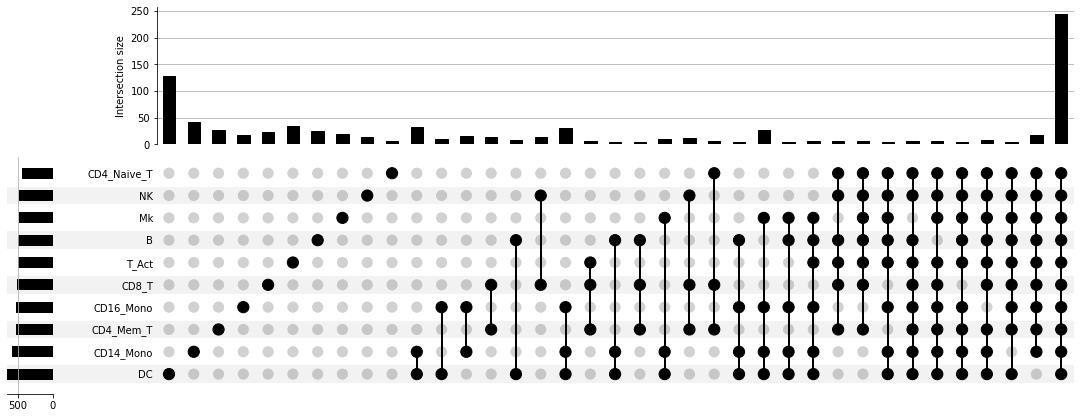

In [82]:
cell_diff = from_contents(top_genes)
ax_dict = UpSet(cell_diff, subset_size='count', orientation='horizontal', min_subset_size=5).plot()


In [83]:

kang_diff_exp_genes = ["CXCL10", "IFIT1", "RSAD2", "IFIT3", "CCL8", "IFI6", "ISG15", "CMPK2", "CXCL11", "IFIT2", "APOBEC3A", "OAS1", "HERC5", "MX1", "OAS3", "ETV7", "IFITM3", "TNFSF13B", "CCL7", "IFI44", "PLSCR1", "IDO1", "LAG3", "GBP1", "NEXN", "MX2", "ISG20", "EPSTI1", "MT2A", "LGALS9", "IL1RN", "IFI44L", "NT5C3A", "TNFSF10", "STAT2", "APOBEC3B", "LAMP3", "IFNG", "AIM2", "SAMD9L", "DDX58"]
all_res[8].loc[kang_diff_exp_genes]

FC    log2FC  abslog2FC
gene_ids                                
CXCL10    14.169910  3.824759   3.824759
IFIT1      7.467165  2.900561   2.900561
RSAD2     16.280788  4.025099   4.025099
IFIT3      8.833914  3.143053   3.143053
CCL8      29.830843  4.898733   4.898733
IFI6       3.835999  1.939602   1.939602
ISG15      1.009632  0.013830   0.013830
CMPK2      7.725155  2.949564   2.949564
CXCL11    48.305805  5.594125   5.594125
IFIT2      3.898233  1.962820   1.962820
APOBEC3A   6.870331  2.780380   2.780380
OAS1       3.647157  1.866772   1.866772
HERC5      4.484133  2.164829   2.164829
MX1        2.858042  1.515027   1.515027
OAS3       7.106814  2.829203   2.829203
ETV7       6.891961  2.784914   2.784914
IFITM3     1.301182  0.379823   0.379823
TNFSF13B   2.280258  1.189197   1.189197
CCL7       3.821007  1.933953   1.933953
IFI44      5.028991  2.330269   2.330269
PLSCR1     1.519618  0.603709   0.603709
IDO1       8.654247  3.113408   3.113408
LAG3      11.354052  3.505135   3.505135
GBP1       2.766235  1.467924   1.467924
NEXN       4.243571  2.085279   2.085279
MX2        4.250620  2.087673   2.087673
ISG20      1.236937  0.306772   0.306772
EPSTI1     4.699003  2.232355   2.232355
MT2A       1.256965  0.329945   0.329945
LGALS9     1.991900  0.994145   0.994145
IL1RN     13.142637  3.716183   3.716183
IFI44L     2.807478  1.489275   1.489275
NT5C3A     1.308917  0.388373   0.388373
TNFSF10    1.538415  0.621445   0.621445
STAT2      4.307452  2.106835   2.106835
APOBEC3B   4.787655  2.259319   2.259319
LAMP3      2.467291  1.302928   1.302928
IFNG       2.849281  1.510598   1.510598
AIM2       2.120759  1.084581   1.084581
SAMD9L     4.877619  2.286177   2.286177
DDX58      2.198400  1.136454   1.136454

In [84]:
a = all_res[8]
a = a.sort_values(by=['log2FC'], ascending=False)
a.iloc[0:41]

FC    log2FC  abslog2FC
gene_ids                                    
ANXA3         54.029648  5.755680   5.755680
CXCL11        48.305805  5.594125   5.594125
CCL8          29.830843  4.898733   4.898733
TREX1         22.022882  4.460931   4.460931
RSAD2         16.280788  4.025099   4.025099
CXCL13        15.108780  3.917315   3.917315
CXCL10        14.169910  3.824759   3.824759
IL1RN         13.142637  3.716183   3.716183
LAG3          11.354052  3.505135   3.505135
SOBP          11.013426  3.461191   3.461191
CXCL9         10.952274  3.453159   3.453159
EXOC2          9.938986  3.313099   3.313099
HESX1          9.892448  3.306328   3.306328
CLEC4C         9.640091  3.269047   3.269047
CCDC146        9.189013  3.199910   3.199910
HRASLS2        8.982819  3.167168   3.167168
IFIT3          8.833914  3.143053   3.143053
IDO1           8.654247  3.113408   3.113408
EXOC3L1        8.486519  3.085173   3.085173
CYP19A1        8.328218  3.058008   3.058008
TGM1           8.021265  3.003830   3.003830
SIGLEC1        7.873478  2.977001   2.977001
SZT2           7.865219  2.975487   2.975487
PDGFRL         7.862986  2.975077   2.975077
DDX60          7.853476  2.973331   2.973331
CMPK2          7.725155  2.949564   2.949564
CCNA1          7.522222  2.911159   2.911159
IFIT1          7.467165  2.900561   2.900561
MED13          7.400755  2.887672   2.887672
OAS3           7.106814  2.829203   2.829203
PI4K2B         7.095788  2.826963   2.826963
SCIN           7.083097  2.824380   2.824380
IL27           6.980074  2.803242   2.803242
RTP4           6.903468  2.787321   2.787321
ETV7           6.891961  2.784914   2.784914
APOBEC3A       6.870331  2.780380   2.780380
TNKS2-AS1      6.815951  2.768915   2.768915
CH25H          6.736174  2.751929   2.751929
MAP1A          6.718696  2.748181   2.748181
BHLHE40-AS1    6.627735  2.728516   2.728516
RP11-356I2.1   6.598293  2.722093   2.722093

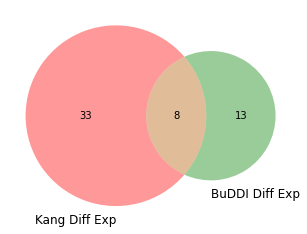

In [85]:
a = all_res[8]
a = a.sort_values(by=['log2FC'], ascending=False)
a.iloc[0:41]


venn2([set(kang_diff_exp_genes), set(a.iloc[np.where(a.log2FC > 3)].index)], set_labels = ('Kang Diff Exp', 'BuDDI Diff Exp'))
plt.show()

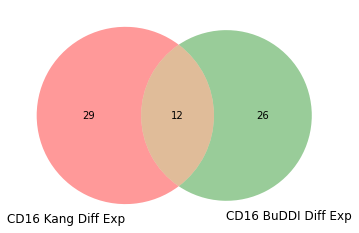

In [86]:
kang_CD16_diff_exp_genes = ["CXCL11", "CCL8", "IL27", "IFIT1", "DEFB1", "HESX1", "ISG15", "RSAD2", "CH25H", "TGM1", "NUPR1", "IDO1", "CD38", "GMPR", "IFIT2", "BCL2L14", "CXCL10", "IFIT3", "CCNA1", "HES4", "PRR5", "CMPK2", "HRASLS2", "MX1", "HERC5", "NT5C3A", "OASL", "ISG20", "SCIN", "APOBEC3A", "MX2", "SAMD4A", "SIGLEC1", "LAG3", "NEXN", "ZBP1", "PNPT1", "SLC38A5", "DHX58", "DDX58", "CACNA1A"]
a = all_res[5]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_CD16_diff_exp_genes), set(a.iloc[np.where(a.log2FC > 3)].index)], set_labels = ('CD16 Kang Diff Exp', 'CD16 BuDDI Diff Exp'))
plt.show()

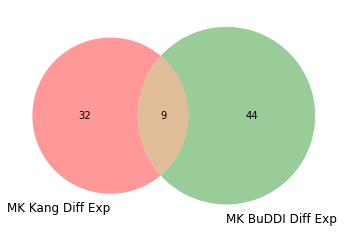

In [87]:
kang_MK_diff_exp_genes = ["RSAD2", "CXCL10", "CCL8", "IFIT3", "MX1", "IDO1", "TREX1", "IFI6", "ISG15", "IFIT1", "CXCL11", "OAS3", "EPSTI1", "TNFSF10", "MT2A", "DDX58", "MX2", "CMPK2", "SPATS2L", "LY6E", "IFI44L", "IL1RN", "SAMD9L", "TRIM22", "TARBP1", "HAPLN3", "EIF2AK2", "IFITM3", "ISG20", "HERC5", "IFI44", "OAS1", "PARP14", "OASL", "APOBEC3A", "IFIH1", "PNPT1", "HELZ2", "PLSCR1", "IFIT2", "HERC6"]

a = all_res[7]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_MK_diff_exp_genes), set(a.iloc[np.where(a.log2FC > 3)].index)], set_labels = ('MK Kang Diff Exp', 'MK BuDDI Diff Exp'))
plt.show()



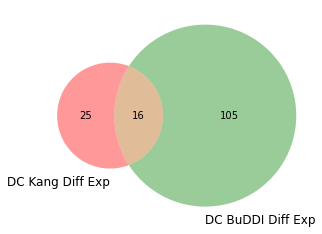

In [88]:
kang_DC_diff_exp_genes = ["IFIT1", "IFIT3", "IFIT2", "TNFSF10", "CXCL10", "CXCL11", "RSAD2", "CMPK2", "CCL8", "ISG15", "APOBEC3A", "ANKRD22", "OASL", "HERC6", "IL1RN", "DDX58", "IFI27", "OAS2", "HERC5", "LAG3", "IFITM3", "OAS1", "HES4", "CD38", "DHX58", "OAS3", "MX1", "IFI6", "TGM1", "ETV7", "IFI44L", "PDGFRL", "SLC38A5", "HESX1", "NT5C3A", "CXCL13", "LY6E", "APOBEC3B", "CXCL9", "GBP5", "NEXN"]


a = all_res[6]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_DC_diff_exp_genes), set(a.iloc[np.where(a.log2FC > 3)].index)], set_labels = ('DC Kang Diff Exp', 'DC BuDDI Diff Exp'))
plt.show()



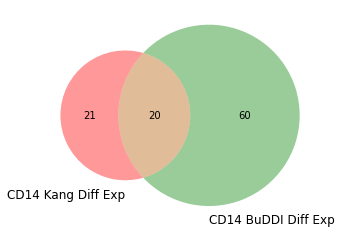

In [89]:
kang_CD14_diff_exp_genes = ["CCL8", "CXCL11", "HESX1", "CXCL10", "CCNA1", "NUPR1", "TGM1", "IFIT1", "IFIT2", "IFIT3", "RSAD2", "HRASLS2", "CD38", "BCL2L14", "ISG15", "IL27", "NEXN", "PDGFRL", "CMPK2", "DEFB1", "HES4", "EDN1", "IL1RN", "IRG1", "BATF2", "SCIN", "NCOA7", "HERC5", "IDO1", "MDK", "PRLR", "RABGAP1L", "APOBEC3A", "LAG3", "IFITM1", "MX1", "ZBP1", "CXCL9", "USP18", "NT5C3A"]



a = all_res[4]
a = a.sort_values(by=['log2FC'], ascending=False)

venn2([set(kang_DC_diff_exp_genes), set(a.iloc[np.where(a.log2FC > 3)].index)], set_labels = ('CD14 Kang Diff Exp', 'CD14 BuDDI Diff Exp'))
plt.show()

